# ANOVA

In [1]:
import pandas as pd
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
    
import matplotlib.pyplot as plt

# Loading data
df = pd.read_csv("https://raw.githubusercontent.com/Opensourcefordatascience/Data-sets/master/difficile.csv")
df.drop('person', axis= 1, inplace= True)

# Recoding value from numeric to string
df['dose'].replace({1: 'placebo', 2: 'low', 3: 'high'}, inplace= True)
    
# Gettin summary statistics
rp.summary_cont(df['libido'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,libido,15.0,3.4667,1.7674,0.4563,2.4879,4.4454


### Data Per Dosing

In [ ]:
rp.summary_cont(df['libido'].groupby(df['dose']))

## One Way ANOVA

In [ ]:
stats.f_oneway(df['libido'][df['dose'] == 'high'], 
             df['libido'][df['dose'] == 'low'],
             df['libido'][df['dose'] == 'placebo'])

In [ ]:
results = ols('libido ~ C(dose)', data=df).fit()
results.summary()

### ANOVA Table with Effect Sizes

In [ ]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

### Check Model Assumptions

In [ ]:
results.diagn

#### Homogeneity of Variance

In [ ]:
stats.levene(df['libido'][df['dose'] == 'placebo'],
             df['libido'][df['dose'] == 'low'],
             df['libido'][df['dose'] == 'high'])

# Not significant indicates that the groups have equal variances

#### Normality

In [ ]:
stats.shapiro(results.resid)

# Not statistically significant which indicates that the residuals are normally distributed

### Post Hoc/ Multiple Comparison

#### Uncorrected Post Hoc

In [ ]:
import scikit_posthocs as sp

sp.posthoc_ttest(df, val_col='libido', group_col='dose', pool_sd=True,
equal_var=True, p_adjust=None, sort=False)

#### FDR Correction

In [ ]:
import scikit_posthocs as sp

sp.posthoc_ttest(df, val_col='libido', group_col='dose', pool_sd=True,
equal_var=True, p_adjust='fdr_by', sort=False)

#### Bonferroni Correction

In [ ]:
import scikit_posthocs as sp

sp.posthoc_ttest(df, val_col='libido', group_col='dose', pool_sd=True,
equal_var=True, p_adjust='bonferroni', sort=False)

#### Tukey HSD

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['libido'], df['dose'])
mc_results = mc.tukeyhsd()
print(mc_results)

## Two Way M-ANOVA

In [ ]:
import pandas
import researchpy as rp
import seaborn as sns
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp



df = pandas.read_csv("https://raw.githubusercontent.com/Opensourcefordatascience/Data-sets/master/crop_yield.csv")

In [ ]:
df['Subject'] = range(1, len(df) + 1)

### Check Means and Descriptives

### Grand Mean (DV)

In [ ]:
rp.summary_cont(df['Yield'])

### Mean DV by each factor

In [ ]:
rp.summary_cont(df.groupby(['Fert']))['Yield']

In [ ]:
rp.summary_cont(df.groupby(['Water']))['Yield']

In [ ]:
rp.summary_cont(df.groupby(['Fert', 'Water']))['Yield']

### Run M-ANOVA (automatically include the main effects for each factor)

In [ ]:
model = ols('Yield ~ C(Fert)*C(Water)', df).fit()

model.summary() 
## Only Attned to top (Overall) and bottom (Assumptions) ##
# The Durban-Watson tests is to detect the presence of autocorrelation (range of 1.5 to 2.5 are relatively normal)
# Jarque-Bera tests the assumption of normality
# Omnibus tests the assumption of homogeneity of variance
# Condition Number assess multicollinearity (values over 20 are indicative of multicollinearity)

### Create the M-ANOVA table

In [ ]:
res = sm.stats.anova_lm(model, typ= 2)
res

### Create M-ANOVA Table with Effect Sizes

In [ ]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(res)

### Rerun without Non-Significant Interaction

In [ ]:
model2 = ols('Yield ~ C(Fert)+ C(Water)', df).fit()
model2.summary()

### Re-Create M-ANOVA table

In [ ]:
res2 = sm.stats.anova_lm(model2, typ= 2)
res2

### Re-Create the M-ANOVA table with Effect Sizes

In [ ]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(res2)

## Post Hoc Test

### First Categorical Variable

In [ ]:
mc = statsmodels.stats.multicomp.MultiComparison(df['Yield'], df['Fert'])
mc_results = mc.tukeyhsd()
print(mc_results)

### Using Pingouin Library

In [ ]:
import pingouin as pg
from pingouin import pairwise_tukey, read_dataset
pt = pairwise_tukey(data=df, dv='Yield', between='Fert')
print(pt)

### Second Categorical Variable

In [ ]:
mc = statsmodels.stats.multicomp.MultiComparison(df['Yield'], df['Water'])
mc_results = mc.tukeyhsd()
print(mc_results)

### Using Pingouin Library

In [ ]:
pt = pairwise_tukey(data=df, dv='Yield', between='Water')
print(pt)

### Interaction from First Model (tukeyhsd)

In [ ]:
pt = pairwise_tukey(data=df, dv='Yield', between='Fert')
print(pt)

### Interaction from First Model (FDR)

In [ ]:
import pingouin as pg

posthocs = pg.pairwise_ttests(dv='Yield', within='Water', between='Fert',
                              subject='Subject', data=df, padjust='fdr_bh')
pg.print_table(posthocs)

In [ ]:
import pingouin as pg

posthocs = pg.pairwise_ttests(dv='Yield', within='Fert', between='Water',
                              subject='Subject', data=df, padjust='fdr_bh')
pg.print_table(posthocs)

# T-test

## Independent T-test

In [ ]:
# Importing the required libraries
import pandas as pd

# Two different methods of conducting a t-test
import researchpy as rp
from scipy import stats


df = pd.read_csv("https://raw.githubusercontent.com/Opensourcefordatascience/Data-sets/master//Iris_Data.csv")

### Create Factor

In [ ]:
setosa = df[(df['species'] == 'Iris-setosa')]
setosa.reset_index(inplace= True)

versicolor = df[(df['species'] == 'Iris-versicolor')]
versicolor.reset_index(inplace= True)

### Test Assumptions (Homogeniety and Normal Distribution)

In [ ]:
stats.levene(setosa['sepal_width'], versicolor['sepal_width'])

In [ ]:
diff = setosa['sepal_width'] - versicolor['sepal_width']
stats.shapiro(diff)

### Descriptives and Results (ResearchPy)

In [ ]:
descriptives, results = rp.ttest(setosa['sepal_width'], versicolor['sepal_width'])
descriptives

In [ ]:
results

## Pairwise T-test

In [ ]:
import pandas as pd
df = pd.read_csv("https://raw.github.com/Opensourcefordatascience/Data-sets/master//blood_pressure.csv")
df[['bp_before','bp_after']].describe()

### Check for Outliers

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

df[['bp_before', 'bp_after']].plot(kind='box')
# This saves the plot as a png file
plt.savefig('boxplot_outliers.png')

### Check for Normality of Distribution Difference Between Variables

In [ ]:
df['bp_difference'] = df['bp_before'] - df['bp_after']

df['bp_difference'].plot(kind='hist', title= 'Blood Pressure Difference Histogram')
#Again, this saves the plot as a png file
plt.savefig('blood pressure difference histogram.png')

### Q-Q Plot to Also Test for Normal Distribution

In [ ]:
stats.probplot(df['bp_difference'], plot= plt)
plt.title('Blood pressure Difference Q-Q Plot')
plt.savefig('blood pressure difference qq plot.png')

### Test Assumptions (Homogeniety and Normal Distribution)

In [ ]:
stats.shapiro(df['bp_difference'])

### Perform Paired Samples T-Test

In [ ]:
stats.ttest_rel(df['bp_before'], df['bp_after'])

# Linear Regression

In [40]:
%matplotlib inline
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.metrics import r2_score
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


In [41]:
car_df = pd.read_csv('ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000] # Reduce data frame to the top 1000 rows and select columns for regression analysis

### Set up Data for Analysis

In [42]:
predictors = ['Automatic']
outcome = 'Price'

# Dummy Code Factors
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]

# Partition Data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

### Regression

In [43]:
car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))
pred_y = car_lm.predict(train_X)

print('r2 : ', r2_score(train_y, pred_y))
print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, car_lm))
print('AIC : ', AIC_score(train_y, pred_y, car_lm))
print('BIC : ', BIC_score(train_y, pred_y, car_lm))

intercept  11721.204946996466
   Predictor  coefficient
0  Automatic   998.942112

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 3689.8136
            Mean Absolute Error (MAE) : 2735.4941
          Mean Percentage Error (MPE) : -8.2080
Mean Absolute Percentage Error (MAPE) : 23.3499
r2 :  0.0039027111230259814
adjusted r2 :  0.0022369965931312574
AIC :  11564.723688919717
BIC :  11577.914477885366


### Use predict() to make predictions on validate/tests partitions

In [44]:
# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)
linear = car_lm
preds_linear = linear.predict(valid_X)
corr_linear = round(pd.Series(preds_linear).corr(
  pd.Series(valid_y)), 3)

        Predicted  Actual      Residual
507  11721.204947   11500   -221.204947
818  11721.204947    8950  -2771.204947
452  11721.204947   11450   -271.204947
368  11721.204947   11450   -271.204947
242  11721.204947   11950    228.795053
929  11721.204947    9995  -1726.204947
262  11721.204947   13500   1778.795053
810  11721.204947    7950  -3771.204947
318  11721.204947    9900  -1821.204947
49   11721.204947   21950  10228.795053
446  11721.204947   11950    228.795053
142  11721.204947   19950   8228.795053
968  11721.204947    9950  -1771.204947
345  11721.204947   14950   3228.795053
971  11721.204947   10495  -1226.204947
133  11721.204947   15950   4228.795053
104  12720.147059   19450   6729.852941
6    11721.204947   16900   5178.795053
600  12720.147059   11250  -1470.147059
496  11721.204947   11750     28.795053

Regression statistics

                      Mean Error (ME) : 229.1046
       Root Mean Squared Error (RMSE) : 3818.6806
            Mean Absolute Error (MAE)

### Plot Residuals in Comparison to Valid Partition

0.3075


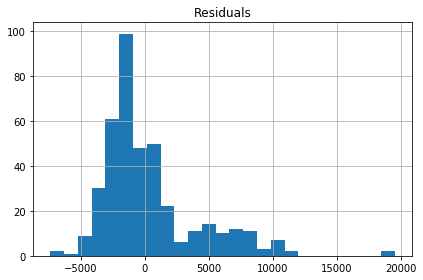

In [45]:
car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm

X = car_df["Automatic"]
y = car_df["Price"]

# Note the difference in argument order
model = sm.OLS(y,X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

# Multiple Regression

In [113]:
%matplotlib inline
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


### Reduce data frame to the top 1000 rows and select columns for regression analysis

In [123]:
car_df = pd.read_csv('ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000]

### Convert Doors to a Categorical Variable

In [124]:
car_df['Doors'] = car_df['Doors'].astype('category')
new_categories = {2: 'Sport', 3: 'SportHatch', 4: 'Sedan', 5: 'Hatch'}
car_df.Doors.cat.rename_categories(new_categories, inplace=True)
car_df.drop(columns=['Id', 'Model'], inplace=True)
car_df=pd.get_dummies(car_df, drop_first=True)
car_df.columns

Index(['Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'HP', 'Met_Color',
       'Automatic', 'CC', 'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight',
       'Mfr_Guarantee', 'BOVAG_Guarantee', 'Guarantee_Period', 'ABS',
       'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer',
       'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering',
       'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar', 'Fuel_Type_Diesel',
       'Fuel_Type_Petrol', 'Color_Black', 'Color_Blue', 'Color_Green',
       'Color_Grey', 'Color_Red', 'Color_Silver', 'Color_Violet',
       'Color_White', 'Color_Yellow', 'Doors_SportHatch', 'Doors_Sedan',
       'Doors_Hatch'],
      dtype='object')

### Create Non-Truncated Lists in Jupyter

In [130]:
pd.options.display.max_seq_items = 2000
car_df.dtypes

Price                int32
Age_08_04            int32
Mfg_Month            int32
Mfg_Year             int32
KM                   int32
HP                   int32
Met_Color            int32
Automatic            int32
CC                   int32
Cylinders            int32
Gears                int32
Quarterly_Tax        int32
Weight               int32
Mfr_Guarantee        int32
BOVAG_Guarantee      int32
Guarantee_Period     int32
ABS                  int32
Airbag_1             int32
Airbag_2             int32
Airco                int32
Automatic_airco      int32
Boardcomputer        int32
CD_Player            int32
Central_Lock         int32
Powered_Windows      int32
Power_Steering       int32
Radio                int32
Mistlamps            int32
Sport_Model          int32
Backseat_Divider     int32
Metallic_Rim         int32
Radio_cassette       int32
Parking_Assistant    int32
Tow_Bar              int32
Fuel_Type_Diesel     int32
Fuel_Type_Petrol     int32
Color_Black          int32
C

In [125]:
car_df = car_df.astype(int)

### Define Predictors and Outcome for Multiple Regression

In [133]:
predictors =['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'HP', 'Met_Color', 
        'Color_Black', 'Color_Blue', 'Color_Green',
       'Color_Grey', 'Color_Red', 'Color_Silver', 'Color_Violet',
       'Color_White', 'Color_Yellow', 'Automatic', 'CC', 'Doors_SportHatch', 'Doors_Sedan', 'Doors_Hatch',
       'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee',
       'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2',
       'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player',
       'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio',
       'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']
outcome = 'Price'

### Partition Data

In [134]:
# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [135]:
# Get column names first
names = predictors
# Create the Scaler object
scaler = StandardScaler()
# Fit your data on the scaler object
scaled_train_X = scaler.fit_transform(train_X)
scaled_valid_X = scaler.transform(valid_X)
scaled_train_X = pd.DataFrame(scaled_train_X, columns=predictors)
scaled_valid_X = pd.DataFrame(scaled_valid_x, columns=predictors)
# Rename
train_X = scaled_train_X
valid_X = scaled_valid_X

### Comprehensive Search to Find All Possible Variables (Slow)

In [ ]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

### Backward Elimination

In [136]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: Age_08_04, Mfg_Month, Mfg_Year, KM, Fuel_Type_Diesel, Fuel_Type_Petrol, HP, Met_Color, Color_Black, Color_Blue, Color_Green, Color_Grey, Color_Red, Color_Silver, Color_Violet, Color_White, Color_Yellow, Automatic, CC, Doors_SportHatch, Doors_Sedan, Doors_Hatch, Cylinders, Gears, Quarterly_Tax, Weight, Mfr_Guarantee, BOVAG_Guarantee, Guarantee_Period, ABS, Airbag_1, Airbag_2, Airco, Automatic_airco, Boardcomputer, CD_Player, Central_Lock, Powered_Windows, Power_Steering, Radio, Mistlamps, Sport_Model, Backseat_Divider, Metallic_Rim, Radio_cassette, Parking_Assistant, Tow_Bar
Start: score=10216.94
Step: score=10214.94, remove Color_Blue
Step: score=10212.93, remove Mfg_Month
Step: score=10210.94, remove Doors_SportHatch
Step: score=10208.94, remove Color_Yellow
Step: score=10206.94, remove Cylinders
Step: score=10204.94, remove Radio_cassette
Step: score=10202.97, remove CC
Step: score=10201.03, remove Gears
Step: score=10199.13, remove Radio
Step: score=10197.27, remove Doors

### Forward Selection

In [137]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: Age_08_04, Mfg_Month, Mfg_Year, KM, Fuel_Type_Diesel, Fuel_Type_Petrol, HP, Met_Color, Color_Black, Color_Blue, Color_Green, Color_Grey, Color_Red, Color_Silver, Color_Violet, Color_White, Color_Yellow, Automatic, CC, Doors_SportHatch, Doors_Sedan, Doors_Hatch, Cylinders, Gears, Quarterly_Tax, Weight, Mfr_Guarantee, BOVAG_Guarantee, Guarantee_Period, ABS, Airbag_1, Airbag_2, Airco, Automatic_airco, Boardcomputer, CD_Player, Central_Lock, Powered_Windows, Power_Steering, Radio, Mistlamps, Sport_Model, Backseat_Divider, Metallic_Rim, Radio_cassette, Parking_Assistant, Tow_Bar
Start: score=11565.07, constant
Step: score=10647.48, add Mfg_Year
Step: score=10511.43, add Automatic_airco
Step: score=10431.78, add HP
Step: score=10373.96, add Weight
Step: score=10312.79, add KM
Step: score=10290.01, add Powered_Windows
Step: score=10266.05, add Quarterly_Tax
Step: score=10251.43, add Sport_Model
Step: score=10232.91, add Guarantee_Period
Step: score=10214.03, add BOVAG_Guarantee
Ste

### Stepwise Selection

In [138]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: Age_08_04, Mfg_Month, Mfg_Year, KM, Fuel_Type_Diesel, Fuel_Type_Petrol, HP, Met_Color, Color_Black, Color_Blue, Color_Green, Color_Grey, Color_Red, Color_Silver, Color_Violet, Color_White, Color_Yellow, Automatic, CC, Doors_SportHatch, Doors_Sedan, Doors_Hatch, Cylinders, Gears, Quarterly_Tax, Weight, Mfr_Guarantee, BOVAG_Guarantee, Guarantee_Period, ABS, Airbag_1, Airbag_2, Airco, Automatic_airco, Boardcomputer, CD_Player, Central_Lock, Powered_Windows, Power_Steering, Radio, Mistlamps, Sport_Model, Backseat_Divider, Metallic_Rim, Radio_cassette, Parking_Assistant, Tow_Bar
Start: score=11565.07, constant
Step: score=10647.48, add Mfg_Year
Step: score=10511.43, add Automatic_airco
Step: score=10431.78, add HP
Step: score=10373.96, add Weight
Step: score=10312.79, add KM
Step: score=10290.01, add Powered_Windows
Step: score=10266.05, add Quarterly_Tax
Step: score=10251.43, add Sport_Model
Step: score=10232.91, add Guarantee_Period
Step: score=10214.03, add BOVAG_Guarantee
Ste

### Re-Import Data with Chosen Variables

In [153]:
### Reduce data frame to the top 1000 rows and select columns for regression analysis

car_df = pd.read_csv('ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000]

In [154]:
### Convert Doors to a Categorical Variable

car_df['Doors'] = car_df['Doors'].astype('category')
new_categories = {2: 'Sport', 3: 'SportHatch', 4: 'Sedan', 5: 'Hatch'}
car_df.Doors.cat.rename_categories(new_categories, inplace=True)
car_df.drop(columns=['Id','Model'], inplace=True)
car_df=pd.get_dummies(car_df, drop_first=True)
car_df.columns

Index(['Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'HP', 'Met_Color',
       'Automatic', 'CC', 'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight',
       'Mfr_Guarantee', 'BOVAG_Guarantee', 'Guarantee_Period', 'ABS',
       'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer',
       'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering',
       'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar', 'Fuel_Type_Diesel',
       'Fuel_Type_Petrol', 'Color_Black', 'Color_Blue', 'Color_Green',
       'Color_Grey', 'Color_Red', 'Color_Silver', 'Color_Violet',
       'Color_White', 'Color_Yellow', 'Doors_SportHatch', 'Doors_Sedan',
       'Doors_Hatch'],
      dtype='object')

In [151]:
car_df = car_df.astype(int)

### Select Predictors from Backward Elimination, Forward Selection or Stepwise Selection

In [155]:
### Define Predictors and Outcome for Multiple Regression

predictors =['Mfg_Year', 'Automatic_airco', 'HP', 'Weight', 'KM', 'Powered_Windows', 'Quarterly_Tax', 
             'Sport_Model', 'Guarantee_Period', 'BOVAG_Guarantee', 'Boardcomputer', 'Color_White', 
             'Metallic_Rim', 'Tow_Bar', 'Doors_Hatch', 'Color_Green', 'Mfr_Guarantee', 'Color_Red', 'Mfg_Month', 'Automatic']
outcome = 'Price'

In [156]:
### Partition Data

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [144]:
# Get column names first
names = predictors
# Create the Scaler object
scaler = StandardScaler()
# Fit your data on the scaler object
scaled_train_X = scaler.fit_transform(train_X)
scaled_valid_x = scaler.transform(valid_X)
scaled_train_X = pd.DataFrame(scaled_train_X, columns=predictors)
scaled_valid_x = pd.DataFrame(scaled_valid_x, columns=predictors)
# Rename
train_X = scaled_train_X
valid_X = scaled_valid_x

In [157]:
car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))

pred_y = car_lm.predict(train_X)

print('Adjusted r2 : ', adjusted_r2_score(train_y, pred_y, car_lm))
print('AIC : ', AIC_score(train_y, pred_y, car_lm))
print('BIC : ', BIC_score(train_y, pred_y, car_lm))

intercept  -3223022.4071055274
           Predictor  coefficient
0           Mfg_Year  1611.260307
1    Automatic_airco  2172.021436
2                 HP    30.043243
3             Weight     6.857817
4                 KM    -0.019126
5    Powered_Windows   544.146062
6      Quarterly_Tax     9.378304
7        Sport_Model   390.937013
8   Guarantee_Period    74.585241
9    BOVAG_Guarantee   876.169510
10     Boardcomputer  -493.775875
11       Color_White  -926.223962
12      Metallic_Rim   276.689861
13           Tow_Bar  -231.686431
14       Doors_Hatch   248.321395
15       Color_Green  -373.157370
16     Mfr_Guarantee   186.737693
17         Color_Red  -244.553065
18         Mfg_Month    22.974437
19         Automatic   320.510252

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1133.3347
            Mean Absolute Error (MAE) : 840.2050
          Mean Percentage Error (MPE) : -0.8132
Mean Absolute Percentage Error (MAPE

### Use predict() to check accuracy of Train Predictions on Valid Partition

        Predicted  Actual     Residual
507  10765.218337   11500   734.781663
818  10267.811808    8950 -1317.811808
452  10244.355844   11450  1205.644156
368  12751.312304   11450 -1301.312304
242  12309.397092   11950  -359.397092
929   9429.216749    9995   565.783251
262  12954.610367   13500   545.389633
810   7687.176456    7950   262.823544
318  11481.026499    9900 -1581.026499
49   20850.072283   21950  1099.927717
446  11208.882770   11950   741.117230
142  20382.204844   19950  -432.204844
968  10761.524075    9950  -811.524075
345  14343.122732   14950   606.877268
971   9036.082162   10495  1458.917838
133  16855.288466   15950  -905.288466
104  18493.672673   19450   956.327327
6    15801.596341   16900  1098.403659
600  11388.005211   11250  -138.005211
496  11846.293833   11750   -96.293833

Regression statistics

                      Mean Error (ME) : 133.1063
       Root Mean Squared Error (RMSE) : 1133.2099
            Mean Absolute Error (MAE) : 880.8458
         

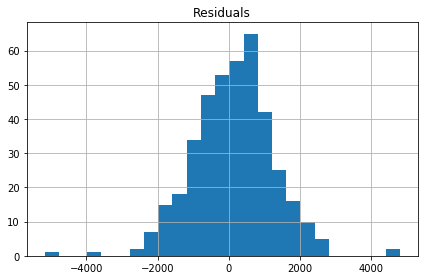

In [158]:
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)

car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Partition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

### Statsmodel: Run Training Model with Included Variables

In [159]:
import statsmodels.api as sm
train_df = train_X.join(train_y)

y = train_df['Price']
X = train_df[['Mfg_Year', 'Automatic_airco', 'HP', 'Weight', 'KM', 'Powered_Windows', 'Quarterly_Tax', 'Sport_Model', 
              'Guarantee_Period', 'BOVAG_Guarantee', 'Boardcomputer', 'Color_White', 'Metallic_Rim', 'Tow_Bar', 
              'Doors_Hatch', 'Color_Green', 'Mfr_Guarantee', 'Color_Red', 'Mfg_Month', 'Automatic']]

# y = DV and X = Predictors
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1756.
Date:                Fri, 06 Mar 2020   Prob (F-statistic):                        0.00
Time:                        19:45:30   Log-Likelihood:                         -5268.0
No. Observations:                 600   AIC:                                  1.058e+04
Df Residuals:                     580   BIC:                                  1.066e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Mfg_Year            -4.1343      0.898     -4.603      0.000      -5.898      -2.370
Automatic_airco   3434.4941    293.449     11.704      0.000    2858.143    4010.846
HP                  24.6053      5.289      4.652      0.000      14.218      34.993
Weight              14.9617      1.749      8.554      0.000      11.527      18.397
KM                  -0.0408      0.002    -17.461      0.000      -0.045      -0.036
Powered_Windows    899.3249    150.282      5.984      0.000     604.162    1194.488
Quarterly_Tax       13.6715      2.312      5.914      0.000       9.131      18.212
Sport_Model        709.3804    155.917      4.550      0.000     403.150    1015.611
Guarantee_Period   182.5080     21.035      8.676      0.000     141.194     223.822
BOVAG_Guarantee    711.1614    258.473      2.751      0.006     203.505    1218.818
Boardcomputer     1408.5952    156.112      9.023      0.000    1101.982    1715.209
Color_White       -568.7249    525.943     -1.081      0.280   -1601.709     464.259
Metallic_Rim        73.4818    171.262      0.429      0.668    -262.888     409.851
Tow_Bar           -513.5437    158.050     -3.249      0.001    -823.964    -203.123
Doors_Hatch        460.5155    141.276      3.260      0.001     183.040     737.991
Color_Green       -682.6539    191.235     -3.570      0.000   -1058.251    -307.057
Mfr_Guarantee      295.1960    142.174      2.076      0.038      15.958     574.434
Color_Red         -458.5943    180.221     -2.545      0.011    -812.559    -104.629
Mfg_Month          -48.5488     20.195     -2.404      0.017     -88.212      -8.886
Automatic          -32.7949    291.428     -0.113      0.910    -605.177     539.587
==============================================================================
Omnibus:                       38.368   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.559
Skew:                           0.178   Prob(JB):                     2.00e-28
Kurtosis:                       5.231   Cond. No.                     5.87e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Statsmodel: Run Train Variables in Valid and/or Test Partitions

In [160]:
import statsmodels.api as sm
valid_df = valid_X.join(valid_y)

y = valid_df['Price']
X = valid_df[['Mfg_Year', 'Automatic_airco', 'HP', 'Weight', 'KM', 'Powered_Windows', 'Quarterly_Tax', 'Sport_Model', 
              'Guarantee_Period', 'BOVAG_Guarantee', 'Boardcomputer', 'Color_White', 'Metallic_Rim', 'Tow_Bar', 
              'Doors_Hatch', 'Color_Green', 'Mfr_Guarantee', 'Color_Red', 'Mfg_Month', 'Automatic']]

# y = DV and X = Predictors
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              1387.
Date:                Fri, 06 Mar 2020   Prob (F-statistic):                        0.00
Time:                        19:45:49   Log-Likelihood:                         -3482.6
No. Observations:                 400   AIC:                                      7005.
Df Residuals:                     380   BIC:                                      7085.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Mfg_Year           -10.5647      1.418     -7.451      0.000     -13.353      -7.777
Automatic_airco   2654.7784    378.041      7.022      0.000    1911.464    3398.093
HP                  21.4934      6.122      3.511      0.001       9.456      33.531
Weight              28.4004      3.022      9.397      0.000      22.458      34.343
KM                  -0.0381      0.003    -14.017      0.000      -0.043      -0.033
Powered_Windows    657.4196    177.458      3.705      0.000     308.498    1006.342
Quarterly_Tax        5.6781      3.557      1.597      0.111      -1.315      12.671
Sport_Model        611.7406    191.923      3.187      0.002     234.376     989.105
Guarantee_Period   167.4810     25.305      6.619      0.000     117.726     217.236
BOVAG_Guarantee    401.5560    261.763      1.534      0.126    -113.129     916.241
Boardcomputer     1395.5101    184.600      7.560      0.000    1032.545    1758.475
Color_White      -1463.1635    671.722     -2.178      0.030   -2783.921    -142.406
Metallic_Rim       103.8594    199.530      0.521      0.603    -288.462     496.181
Tow_Bar           -201.6367    186.468     -1.081      0.280    -568.275     165.002
Doors_Hatch       -126.9852    171.054     -0.742      0.458    -463.316     209.346
Color_Green       -423.7691    233.379     -1.816      0.070    -882.644      35.106
Mfr_Guarantee      343.5208    163.506      2.101      0.036      22.030     665.011
Color_Red         -111.0998    200.957     -0.553      0.581    -506.227     284.028
Mfg_Month          -49.2094     23.463     -2.097      0.037     -95.343      -3.075
Automatic         -204.7178    419.478     -0.488      0.626   -1029.506     620.070
==============================================================================
Omnibus:                       15.030   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.215
Skew:                           0.422   Prob(JB):                     0.000301
Kurtosis:                       3.509   Cond. No.                     6.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Run Regression

### Lasso, Lasso_CV, Ridge, and BayesianRidge Regularized Methods

In [ ]:
lasso = Lasso(normalize=True, alpha=1)
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))
lasso.predict(train_X)
print('The Train r-square is {}'.format(lasso.score(train_X, train_y)))
lasso.predict(valid_X)
print('The Valid r-square is {}'.format(lasso.score(valid_X, valid_y))) 
print('Lasso chosen regularization: ', lasso.alpha)
print(lasso.coef_)

print(result.head(20))
pred_y = lasso.predict(valid_X)

# Compute common accuracy measures
regressionSummary(valid_y, lasso.predict(valid_X))

car_lm_pred = lasso.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Partition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

In [ ]:
lasso_cv = LassoCV(normalize=True, cv=5)
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
lasso_cv.predict(train_X)
print('The Train r-square is {}'.format(lasso_cv.score(train_X, train_y))) 
lasso_cv.predict(valid_X)
print('The Valid r-square is {}'.format(lasso_cv.score(valid_X, valid_y))) 
print('Lasso-CV chosen regularization: ', lasso_cv.alpha_)
print(lasso_cv.coef_)

print(result.head(20))
pred_y = lasso_cv.predict(valid_X)

# Compute common accuracy measures
regressionSummary(valid_y, lasso_cv.predict(valid_X))

car_lm_pred = lasso_cv.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Partition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

In [ ]:
ridge = Ridge(normalize=True, alpha=1)
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))
ridge.predict(train_X)
print('The Train r-square is {}'.format(ridge.score(train_X, train_y))) 
ridge.predict(valid_X)
print('The Valid r-square is {}'.format(ridge.score(valid_X, valid_y))) 
print('Ridge chosen regularization: ', ridge.alpha)
print(ridge.coef_)

print(result.head(20))
pred_y = ridge.predict(valid_X)

# Compute common accuracy measures
regressionSummary(valid_y, ridge.predict(valid_X))

car_lm_pred = ridge.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Partition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

In [ ]:
bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
bayesianRidge.predict(train_X)
print('The Train r-square is {}'.format(bayesianRidge.score(train_X, train_y))) 
bayesianRidge.predict(valid_X)
print('The Valid r-square is {}'.format(bayesianRidge.score(valid_X, valid_y))) 
print('Bayesian ridge chosen regularization: ', bayesianRidge.lambda_ / bayesianRidge.alpha_)
print(bayesianRidge.coef_)

print(result.head(20))
pred_y = bayesianRidge.predict(valid_X)

# Compute common accuracy measures
regressionSummary(valid_y, bayesianRidge.predict(valid_X))

car_lm_pred = bayesianRidge.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Partition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

### Data Frame of Model Coefficients

In [ ]:
df = pd.DataFrame({'features': train_X.columns,
              'linear regression': car_lm.coef_, 
              'lasso': lasso.coef_,
              'lassoCV': lasso_cv.coef_,
              'ridge': ridge.coef_,
              'bayesianRidge': bayesianRidge.coef_})
df.round(5)

# Support Vector Machine: Classification

In [130]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.datasets import load_breast_cancer 
from sklearn.svm import SVC 
  
cancer = load_breast_cancer() 
  
# The data set is presented in a dictionary form: 
print(cancer.keys()) 

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [131]:
df_feat = pd.DataFrame(cancer['data'], 
                       columns = cancer['feature_names']) 
  
# cancer column is our target 
df_target = pd.DataFrame(cancer['target'],  
                     columns =['Cancer']) 
  
print("Feature Variables: ") 
print(df_feat.info()) 

Feature Variables: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smooth

In [132]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_feat,
                                                    np.ravel(df_target),
                                                    test_size=0.30,
                                                    random_state=101)

              precision    recall  f1-score   support

           0       0.95      0.85      0.90        66
           1       0.91      0.97      0.94       105

    accuracy                           0.92       171
   macro avg       0.93      0.91      0.92       171
weighted avg       0.93      0.92      0.92       171



NameError: name 'grid' is not defined

In [153]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_feat,
                                                    np.ravel(df_target),
                                                    test_size=0.30,
                                                    random_state=101)

from sklearn.model_selection import GridSearchCV 

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf'],
              'max_iter': list(range(-1, 100, 1))}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 2525 candidates, totalling 12625 fits
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=-1 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=-1, score=0.637, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=-1 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=-1, score=0.637, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=-1 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=-1, score=0.625, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=-1 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=-1, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=-1 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=-1, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=0 ..........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=0, score=0.637, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=0 .....................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=9, score=0.625, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=9 ..........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=9, score=0.625, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=9 ..........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=9, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=9 ..........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=9, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=10 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=10, score=0.637, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=10 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=10, score=0.625, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=10 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=10, score=0.625, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=10 ...............

[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=21, score=0.625, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=21 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=21, score=0.613, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=21 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=21, score=0.608, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=21 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=21, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=22 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=22, score=0.675, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=22 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=22, score=0.625, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=22 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=22, score=0.613, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=22 ...........

[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=40, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=41 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=41, score=0.675, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=41 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=41, score=0.637, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=41 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=41, score=0.613, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=41 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=41, score=0.620, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=41 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=41, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=42 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=42, score=0.675, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=42 ...........

[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=57, score=0.688, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=57 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=57, score=0.650, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=57 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=57, score=0.625, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=57 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=57, score=0.620, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=57 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=57, score=0.646, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=58 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=58, score=0.688, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=58 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=58, score=0.650, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=58 ...........

[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=70, score=0.620, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=70 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=70, score=0.658, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=71 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=71, score=0.662, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=71 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=71, score=0.637, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=71 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=71, score=0.613, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=71 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=71, score=0.620, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=71 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=71, score=0.658, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=72 ...........

[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=82, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=82 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=82, score=0.671, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=83 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=83, score=0.675, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=83 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=83, score=0.662, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=83 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=83, score=0.613, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=83 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=83, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=83 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=83, score=0.671, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=84 ...........

[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=97, score=0.671, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=98 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=98, score=0.662, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=98 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=98, score=0.675, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=98 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=98, score=0.637, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=98 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=98, score=0.633, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=98 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=98, score=0.671, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=99 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=99, score=0.662, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=99 ...........

[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=17, score=0.750, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=17 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=17, score=0.696, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=17 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=17, score=0.684, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=18 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=18, score=0.637, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=18 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=18, score=0.637, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=18 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=18, score=0.787, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=18 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=18, score=0.709, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_ite

[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=35, score=0.759, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=35 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=35, score=0.772, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=36 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=36, score=0.637, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=36 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=36, score=0.637, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=36 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=36, score=0.825, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=36 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=36, score=0.759, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=36 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=36, score=0.772, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_ite

[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=52, score=0.637, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=52 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=52, score=0.875, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=52 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=52, score=0.797, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=52 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=52, score=0.797, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=53 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=53, score=0.637, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=53 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=53, score=0.637, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=53 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=53, score=0.875, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_ite

[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=65, score=0.810, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=66 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=66, score=0.825, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=66 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=66, score=0.850, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=66 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=66, score=0.838, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=66 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=66, score=0.823, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=66 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=66, score=0.810, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=67 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=67, score=0.825, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_ite

[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=77, score=0.848, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=77 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=77, score=0.785, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=78 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=78, score=0.850, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=78 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=78, score=0.875, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=78 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=78, score=0.850, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=78 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=78, score=0.848, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=78 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=78, score=0.785, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_ite

[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=93, score=0.785, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=94 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=94, score=0.838, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=94 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=94, score=0.850, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=94 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=94, score=0.863, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=94 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=94, score=0.861, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=94 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=94, score=0.785, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=95 .......................
[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=95, score=0.838, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_ite

[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=7, score=0.354, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=8 .......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=8, score=0.375, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=8 .......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=8, score=0.438, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=8 .......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=8, score=0.625, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=8 .......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=8, score=0.620, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=8 .......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=8, score=0.633, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=9 .......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=9, score=0.388, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_it

[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=21, score=0.775, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=21 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=21, score=0.750, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=21 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=21, score=0.620, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=21 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=21, score=0.886, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=22 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=22, score=0.863, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=22 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=22, score=0.650, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=22 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=22, score=0.600, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf,

[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=37, score=0.861, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=37 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=37, score=0.886, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=38 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=38, score=0.875, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=38 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=38, score=0.887, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=38 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=38, score=0.887, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=38 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=38, score=0.899, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=38 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=38, score=0.886, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf,

[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=52, score=0.838, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=52 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=52, score=0.899, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=52 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=52, score=0.873, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=53 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=53, score=0.875, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=53 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=53, score=0.875, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=53 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=53, score=0.863, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=53 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=53, score=0.899, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf,

[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=65, score=0.911, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=65 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=65, score=0.848, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=66 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=66, score=0.812, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=66 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=66, score=0.875, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=66 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=66, score=0.825, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=66 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=66, score=0.924, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=66 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=66, score=0.848, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf,

[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=77 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=77, score=0.838, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=77 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=77, score=0.899, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=77 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=77, score=0.810, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=78 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=78, score=0.838, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=78 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=78, score=0.875, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=78 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=78, score=0.838, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=78 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_

[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=92, score=0.848, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=93 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=93, score=0.812, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=93 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=93, score=0.850, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=93 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=93, score=0.812, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=93 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=93, score=0.861, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=93 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=93, score=0.848, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf, max_iter=94 ......................
[CV]  C=0.1, gamma=0.01, kernel=rbf, max_iter=94, score=0.825, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf,

[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=5, score=0.450, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=5 ......................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=5, score=0.625, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=5 ......................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=5, score=0.456, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=5 ......................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=5, score=0.620, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=6 ......................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=6, score=0.650, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=6 ......................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=6, score=0.600, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=6 ......................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=6, score=0.600, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf

[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=28, score=0.938, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=28 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=28, score=0.962, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=28 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=28, score=0.924, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=29 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=29, score=0.838, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=29 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=29, score=0.887, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=29 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=29, score=0.925, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=29 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=29, score=0.962, total=   0.0s
[CV] C=0.1, gamma=0.001, ker

[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=39, score=0.937, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=40 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=40, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=40 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=40, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=40 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=40, score=0.938, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=40 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=40, score=0.975, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=40 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=40, score=0.937, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=41 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=41, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.001, ker

[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=56, score=0.937, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=57 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=57, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=57 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=57, score=0.887, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=57 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=57, score=0.925, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=57 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=57, score=0.962, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=57 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=57, score=0.937, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=58 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=58, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.001, ker

[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=72, score=0.912, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=72 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=72, score=0.937, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=72 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=72, score=0.911, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=73 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=73, score=0.887, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=73 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=73, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=73 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=73, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=73 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=73, score=0.937, total=   0.0s
[CV] C=0.1, gamma=0.001, ker

[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=85, score=0.899, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=86 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=86, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=86 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=86, score=0.912, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=86 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=86, score=0.925, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=86 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=86, score=0.949, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=86 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=86, score=0.899, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=87 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=87, score=0.887, total=   0.0s
[CV] C=0.1, gamma=0.001, ker

[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=98, score=0.912, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=98 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=98, score=0.937, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=98 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=98, score=0.899, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=99 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=99, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=99 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=99, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=99 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=99, score=0.912, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf, max_iter=99 .....................
[CV]  C=0.1, gamma=0.001, kernel=rbf, max_iter=99, score=0.924, total=   0.0s
[CV] C=0.1, gamma=0.001, ker

[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=8, score=0.671, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=8 .....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=8, score=0.646, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=9 .....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=9, score=0.675, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=9 .....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=9, score=0.675, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=9 .....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=9, score=0.713, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=9 .....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=9, score=0.658, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=9 .....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=9, score=0.658, total=   0.0s
[CV] C=0.1, gamma=0.0001, ke

[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=20, score=0.688, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=20 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=20, score=0.613, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=20 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=20, score=0.684, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=20 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=20, score=0.848, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=21 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=21, score=0.725, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=21 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=21, score=0.725, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=21 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=21, score=0.738, total=   0.0s
[CV] C=0.1, gamma=0.0

[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=31, score=0.863, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=31 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=31, score=0.962, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=31 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=31, score=0.949, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=32 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=32, score=0.912, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=32 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=32, score=0.950, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=32 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=32, score=0.838, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=32 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=32, score=0.962, total=   0.0s
[CV] C=0.1, gamma=0.0

[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=51, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=51 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=51, score=0.950, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=51 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=51, score=0.963, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=51 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=51, score=0.962, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=51 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=51, score=0.924, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=52 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=52, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=52 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=52, score=0.950, total=   0.0s
[CV] C=0.1, gamma=0.0

[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=66, score=0.924, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=67 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=67, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=67 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=67, score=0.963, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=67 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=67, score=0.963, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=67 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=67, score=0.962, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=67 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=67, score=0.924, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=68 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=68, score=0.900, total=   0.0s
[CV] C=0.1, gamma=0.0

[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=82, score=0.899, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=83 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=83, score=0.887, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=83 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=83, score=0.938, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=83 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=83, score=0.963, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=83 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=83, score=0.962, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=83 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=83, score=0.899, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=84 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=84, score=0.887, total=   0.0s
[CV] C=0.1, gamma=0.0

[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=97, score=0.938, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=97 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=97, score=0.963, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=97 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=97, score=0.962, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=97 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=97, score=0.886, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=98 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=98, score=0.887, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=98 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=98, score=0.925, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf, max_iter=98 ....................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, max_iter=98, score=0.963, total=   0.0s
[CV] C=0.1, gamma=0.0

[CV]  C=1, gamma=1, kernel=rbf, max_iter=16, score=0.625, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=16 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=16, score=0.608, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=16 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=16, score=0.633, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=17 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=17, score=0.650, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=17 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=17, score=0.625, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=17 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=17, score=0.625, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=17 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=17, score=0.608, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=17 ...........................

[CV]  C=1, gamma=1, kernel=rbf, max_iter=35, score=0.633, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=36 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=36, score=0.675, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=36 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=36, score=0.637, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=36 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=36, score=0.613, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=36 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=36, score=0.620, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=36 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=36, score=0.633, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=37 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=37, score=0.675, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=37 ...........................

[CV]  C=1, gamma=1, kernel=rbf, max_iter=52, score=0.637, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=52 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=52, score=0.625, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=52 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=52, score=0.620, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=52 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=52, score=0.633, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=53 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=53, score=0.688, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=53 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=53, score=0.637, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=53 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=53, score=0.625, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=53 ...........................

[CV]  C=1, gamma=1, kernel=rbf, max_iter=65, score=0.658, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=66 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=66, score=0.650, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=66 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=66, score=0.637, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=66 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=66, score=0.600, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=66 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=66, score=0.620, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=66 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=66, score=0.658, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=67 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=67, score=0.650, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=67 ...........................

[CV]  C=1, gamma=1, kernel=rbf, max_iter=77, score=0.613, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=77 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=77, score=0.633, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=77 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=77, score=0.671, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=78 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=78, score=0.675, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=78 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=78, score=0.662, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=78 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=78, score=0.613, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=78 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=78, score=0.633, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=78 ...........................

[CV]  C=1, gamma=1, kernel=rbf, max_iter=93, score=0.633, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=93 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=93, score=0.671, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=94 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=94, score=0.662, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=94 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=94, score=0.675, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=94 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=94, score=0.637, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=94 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=94, score=0.633, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=94 ...........................
[CV]  C=1, gamma=1, kernel=rbf, max_iter=94, score=0.671, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf, max_iter=95 ...........................

[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=5, score=0.688, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=5 ..........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=5, score=0.658, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=5 ..........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=5, score=0.671, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=6 ..........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=6, score=0.700, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=6 ..........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=6, score=0.650, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=6 ..........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=6, score=0.662, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=6 ..........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=6, score=0.671, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=6 ...................

[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=18, score=0.750, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=18 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=18, score=0.787, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=18 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=18, score=0.709, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=18 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=18, score=0.709, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=19 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=19, score=0.750, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=19 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=19, score=0.762, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=19 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=19, score=0.800, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=19 ...........

[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=37, score=0.825, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=37 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=37, score=0.759, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=37 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=37, score=0.772, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=38 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=38, score=0.800, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=38 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=38, score=0.825, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=38 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=38, score=0.825, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=38 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=38, score=0.759, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=38 ...........

[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=54, score=0.812, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=54 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=54, score=0.863, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=54 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=54, score=0.875, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=54 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=54, score=0.797, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=54 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=54, score=0.797, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=55 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=55, score=0.812, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=55 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=55, score=0.875, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=55 ...........

[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=67, score=0.835, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=67 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=67, score=0.785, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=68 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=68, score=0.825, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=68 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=68, score=0.850, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=68 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=68, score=0.838, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=68 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=68, score=0.835, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=68 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=68, score=0.785, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=69 ...........

[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=79, score=0.861, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=79 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=79, score=0.785, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=80 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=80, score=0.838, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=80 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=80, score=0.875, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=80 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=80, score=0.850, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=80 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=80, score=0.861, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=80 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=80, score=0.785, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=81 ...........

[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=95, score=0.850, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=95 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=95, score=0.863, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=95 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=95, score=0.861, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=95 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=95, score=0.797, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=96 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=96, score=0.838, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=96 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=96, score=0.850, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=96 .........................
[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=96, score=0.863, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=96 ...........

[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=10, score=0.463, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=10 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=10, score=0.512, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=10 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=10, score=0.405, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=10 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=10, score=0.354, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=11 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=11, score=0.425, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=11 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=11, score=0.450, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=11 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=11, score=0.388, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=11 ...

[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=22, score=0.762, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=22 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=22, score=0.637, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=22 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=22, score=0.873, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=22 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=22, score=0.886, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=23 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=23, score=0.875, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=23 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=23, score=0.637, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=23 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=23, score=0.625, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=23 ...

[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=42, score=0.887, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=42 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=42, score=0.900, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=42 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=42, score=0.900, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=42 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=42, score=0.924, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=42 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=42, score=0.886, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=43 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=43, score=0.887, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=43 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=43, score=0.900, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=43 ...

[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=57, score=0.650, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=57 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=57, score=0.633, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=57 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=57, score=0.873, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=58 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=58, score=0.875, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=58 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=58, score=0.887, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=58 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=58, score=0.650, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=58 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=58, score=0.646, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=58 ...

[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=70, score=0.924, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=70 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=70, score=0.861, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=71 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=71, score=0.838, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=71 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=71, score=0.863, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=71 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=71, score=0.863, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=71 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=71, score=0.937, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=71 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=71, score=0.861, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=72 ...

[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=82, score=0.848, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=83 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=83, score=0.863, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=83 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=83, score=0.875, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=83 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=83, score=0.850, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=83 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=83, score=0.899, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=83 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=83, score=0.848, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=84 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=84, score=0.850, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=84 ...

[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=99, score=0.850, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=99 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=99, score=0.863, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=99 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=99, score=0.886, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf, max_iter=99 ........................
[CV]  C=1, gamma=0.01, kernel=rbf, max_iter=99, score=0.848, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=-1 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=-1, score=0.900, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=-1 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=-1, score=0.912, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=-1 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=-1, score=0.925, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=-1

[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=9, score=0.608, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=10 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=10, score=0.450, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=10 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=10, score=0.500, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=10 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=10, score=0.438, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=10 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=10, score=0.418, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=10 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=10, score=0.342, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=11 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=11, score=0.438, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter

[CV] C=1, gamma=0.001, kernel=rbf, max_iter=23 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=23, score=0.900, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=23 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=23, score=0.938, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=23 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=23, score=0.962, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=23 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=23, score=0.899, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=24 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=24, score=0.912, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=24 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=24, score=0.900, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=24 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=24

[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=42, score=0.975, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=42 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=42, score=0.911, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=43 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=43, score=0.925, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=43 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=43, score=0.912, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=43 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=43, score=0.938, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=43 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=43, score=0.975, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=43 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=43, score=0.924, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_ite

[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=59, score=0.900, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=59 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=59, score=0.925, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=59 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=59, score=0.962, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=59 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=59, score=0.949, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=60 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=60, score=0.912, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=60 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=60, score=0.900, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=60 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=60, score=0.925, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_ite

[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=75, score=0.912, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=75 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=75, score=0.887, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=75 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=75, score=0.925, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=75 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=75, score=0.962, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=75 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=75, score=0.949, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=76 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=76, score=0.912, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=76 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=76, score=0.887, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_ite

[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=89, score=0.949, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=90 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=90, score=0.900, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=90 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=90, score=0.887, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=90 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=90, score=0.925, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=90 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=90, score=0.962, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=90 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=90, score=0.949, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_iter=91 .......................
[CV]  C=1, gamma=0.001, kernel=rbf, max_iter=91, score=0.900, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf, max_ite

[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=6, score=0.443, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=7 .......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=7, score=0.600, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=7 .......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=7, score=0.688, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=7 .......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=7, score=0.500, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=7 .......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=7, score=0.430, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=7 .......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=7, score=0.405, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=8 .......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=8, score=0.688, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_it

[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=21, score=0.962, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=21 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=21, score=0.582, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=22 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=22, score=0.900, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=22 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=22, score=0.725, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=22 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=22, score=0.900, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=22 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=22, score=0.873, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=22 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=22, score=0.734, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf,

[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=34, score=0.975, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=34 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=34, score=0.962, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=34 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=34, score=0.937, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=35 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=35, score=0.912, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=35 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=35, score=0.950, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=35 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=35, score=0.975, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=35 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=35, score=0.962, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf,

[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=46, score=0.950, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=46 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=46, score=0.975, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=46 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=46, score=0.962, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=46 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=46, score=0.937, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=47 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=47, score=0.900, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=47 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=47, score=0.950, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=47 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=47, score=0.975, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf,

[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=57, score=0.975, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=57 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=57, score=0.962, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=57 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=57, score=0.937, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=58 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=58, score=0.912, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=58 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=58, score=0.950, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=58 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=58, score=0.975, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=58 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=58, score=0.962, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf,

[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=77, score=0.937, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=78 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=78, score=0.912, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=78 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=78, score=0.950, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=78 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=78, score=0.975, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=78 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=78, score=0.962, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=78 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=78, score=0.937, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=79 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=79, score=0.912, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf,

[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=97, score=0.975, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=97 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=97, score=0.962, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=97 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=97, score=0.937, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=98 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=98, score=0.912, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=98 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=98, score=0.950, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=98 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=98, score=0.975, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf, max_iter=98 ......................
[CV]  C=1, gamma=0.0001, kernel=rbf, max_iter=98, score=0.962, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf,

[CV]  C=10, gamma=1, kernel=rbf, max_iter=19, score=0.633, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=20 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=20, score=0.662, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=20 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=20, score=0.625, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=20 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=20, score=0.625, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=20 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=20, score=0.608, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=20 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=20, score=0.633, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=21 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=21, score=0.675, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=21 ...................

[CV]  C=10, gamma=1, kernel=rbf, max_iter=40, score=0.380, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=40 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=40, score=0.633, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=41 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=41, score=0.388, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=41 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=41, score=0.400, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=41 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=41, score=0.400, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=41 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=41, score=0.380, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=41 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=41, score=0.633, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=42 ...................

[CV]  C=10, gamma=1, kernel=rbf, max_iter=57, score=0.388, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=57 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=57, score=0.400, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=57 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=57, score=0.400, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=57 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=57, score=0.380, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=57 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=57, score=0.367, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=58 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=58, score=0.388, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=58 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=58, score=0.400, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=58 ...................

[CV]  C=10, gamma=1, kernel=rbf, max_iter=70, score=0.367, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=71 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=71, score=0.388, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=71 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=71, score=0.400, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=71 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=71, score=0.412, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=71 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=71, score=0.380, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=71 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=71, score=0.367, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=72 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=72, score=0.388, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=72 ...................

[CV]  C=10, gamma=1, kernel=rbf, max_iter=82, score=0.367, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=83 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=83, score=0.388, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=83 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=83, score=0.412, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=83 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=83, score=0.412, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=83 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=83, score=0.380, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=83 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=83, score=0.367, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=84 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=84, score=0.388, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=84 ...................

[CV]  C=10, gamma=1, kernel=rbf, max_iter=99, score=0.375, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=99 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=99, score=0.388, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=99 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=99, score=0.388, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=99 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=99, score=0.380, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf, max_iter=99 ..........................
[CV]  C=10, gamma=1, kernel=rbf, max_iter=99, score=0.367, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=-1 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=-1, score=0.637, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=-1 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=-1, score=0.637, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=-1 .............

[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=20, score=0.500, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=20 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=20, score=0.557, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=20 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=20, score=0.506, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=21 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=21, score=0.637, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=21 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=21, score=0.637, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=21 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=21, score=0.512, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=21 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=21, score=0.582, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=21 ...

[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=38, score=0.671, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=38 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=38, score=0.633, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=39 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=39, score=0.637, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=39 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=39, score=0.637, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=39 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=39, score=0.588, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=39 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=39, score=0.671, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=39 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=39, score=0.658, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=40 ...

[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=54, score=0.762, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=54 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=54, score=0.662, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=54 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=54, score=0.722, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=54 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=54, score=0.747, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=55 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=55, score=0.650, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=55 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=55, score=0.775, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=55 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=55, score=0.662, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=55 ...

[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=67, score=0.772, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=67 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=67, score=0.785, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=68 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=68, score=0.675, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=68 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=68, score=0.787, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=68 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=68, score=0.662, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=68 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=68, score=0.772, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=68 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=68, score=0.785, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=69 ...

[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=84, score=0.650, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=84 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=84, score=0.797, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=84 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=84, score=0.861, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=85 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=85, score=0.700, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=85 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=85, score=0.787, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=85 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=85, score=0.650, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=85 ........................
[CV]  C=10, gamma=0.1, kernel=rbf, max_iter=85, score=0.810, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf, max_iter=85 ...

[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=-1, score=0.613, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=-1 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=-1, score=0.633, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=-1 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=-1, score=0.633, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=0 ........................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=0, score=0.637, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=0 ........................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=0, score=0.637, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=0 ........................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=0, score=0.625, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=0 ........................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=0, score=0.633, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=0 

[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=12, score=0.354, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=13 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=13, score=0.650, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=13 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=13, score=0.650, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=13 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=13, score=0.613, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=13 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=13, score=0.620, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=13 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=13, score=0.354, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=14 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=14, score=0.650, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_ite

[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=25, score=0.637, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=25 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=25, score=0.625, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=25 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=25, score=0.620, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=25 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=25, score=0.494, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=26 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=26, score=0.662, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=26 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=26, score=0.637, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=26 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=26, score=0.600, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_ite

[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=44, score=0.650, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=44 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=44, score=0.650, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=44 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=44, score=0.620, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=44 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=44, score=0.608, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=45 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=45, score=0.662, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=45 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=45, score=0.650, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=45 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=45, score=0.650, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_ite

[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=60, score=0.675, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=60 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=60, score=0.650, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=60 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=60, score=0.787, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=60 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=60, score=0.633, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=60 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=60, score=0.734, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=61 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=61, score=0.675, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=61 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=61, score=0.662, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_ite

[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=73, score=0.662, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=73 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=73, score=0.838, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=73 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=73, score=0.633, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=73 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=73, score=0.797, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=74 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=74, score=0.838, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=74 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=74, score=0.675, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=74 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=74, score=0.838, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_ite

[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=85, score=0.838, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=85 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=85, score=0.911, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=85 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=85, score=0.861, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=86 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=86, score=0.850, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=86 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=86, score=0.863, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=86 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=86, score=0.838, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_iter=86 .......................
[CV]  C=10, gamma=0.01, kernel=rbf, max_iter=86, score=0.899, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf, max_ite

[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=1, score=0.762, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=1 .......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=1, score=0.825, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=1 .......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=1, score=0.787, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=1 .......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=1, score=0.823, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=1 .......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=1, score=0.722, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=2 .......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=2, score=0.388, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=2 .......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=2, score=0.412, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_it

[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=15, score=0.700, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=15 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=15, score=0.637, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=15 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=15, score=0.625, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=15 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=15, score=0.633, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=15 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=15, score=0.658, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=16 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=16, score=0.688, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=16 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=16, score=0.637, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf,

[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=28, score=0.887, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=28 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=28, score=0.675, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=28 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=28, score=0.725, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=28 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=28, score=0.709, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=28 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=28, score=0.709, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=29 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=29, score=0.887, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=29 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=29, score=0.675, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf,

[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=39, score=0.900, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=39 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=39, score=0.887, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=39 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=39, score=0.924, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=39 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=39, score=0.924, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=40 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=40, score=0.912, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=40 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=40, score=0.900, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=40 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=40, score=0.887, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf,

[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=58, score=0.912, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=58 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=58, score=0.949, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=58 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=58, score=0.937, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=59 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=59, score=0.887, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=59 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=59, score=0.900, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=59 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=59, score=0.912, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=59 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=59, score=0.949, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf,

[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=75, score=0.925, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=75 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=75, score=0.949, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=75 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=75, score=0.924, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=76 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=76, score=0.900, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=76 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=76, score=0.900, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=76 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=76, score=0.925, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=76 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=76, score=0.937, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf,

[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=90, score=0.924, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=91 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=91, score=0.900, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=91 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=91, score=0.912, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=91 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=91, score=0.912, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=91 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=91, score=0.924, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=91 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=91, score=0.924, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf, max_iter=92 ......................
[CV]  C=10, gamma=0.001, kernel=rbf, max_iter=92, score=0.900, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf,

[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=9, score=0.637, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=9 ......................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=9, score=0.425, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=9 ......................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=9, score=0.620, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=9 ......................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=9, score=0.392, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=10 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=10, score=0.688, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=10 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=10, score=0.662, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=10 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=10, score=0.375, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=

[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=24, score=0.762, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=24 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=24, score=0.544, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=24 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=24, score=0.810, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=25 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=25, score=0.825, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=25 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=25, score=0.887, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=25 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=25, score=0.863, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=25 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=25, score=0.646, total=   0.0s
[CV] C=10, gamma=0.0001, ker

[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=37, score=0.937, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=38 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=38, score=0.900, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=38 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=38, score=0.950, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=38 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=38, score=0.863, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=38 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=38, score=0.962, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=38 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=38, score=0.937, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=39 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=39, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, ker

[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=50, score=0.963, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=50 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=50, score=0.949, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=50 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=50, score=0.937, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=51 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=51, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=51 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=51, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=51 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=51, score=0.963, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=51 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=51, score=0.962, total=   0.0s
[CV] C=10, gamma=0.0001, ker

[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=62, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=62 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=62, score=0.963, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=62 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=62, score=0.949, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=62 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=62, score=0.949, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=63 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=63, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=63 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=63, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=63 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=63, score=0.963, total=   0.0s
[CV] C=10, gamma=0.0001, ker

[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=74, score=0.938, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=74 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=74, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=74 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=74, score=0.963, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=74 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=74, score=0.962, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=74 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=74, score=0.937, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=75 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=75, score=0.938, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=75 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=75, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, ker

[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=85, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=85 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=85, score=0.963, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=85 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=85, score=0.949, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=85 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=85, score=0.937, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=86 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=86, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=86 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=86, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=86 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=86, score=0.963, total=   0.0s
[CV] C=10, gamma=0.0001, ker

[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=96, score=0.963, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=96 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=96, score=0.949, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=96 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=96, score=0.937, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=97 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=97, score=0.925, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=97 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=97, score=0.912, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=97 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=97, score=0.963, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf, max_iter=97 .....................
[CV]  C=10, gamma=0.0001, kernel=rbf, max_iter=97, score=0.949, total=   0.0s
[CV] C=10, gamma=0.0001, ker

[CV]  C=100, gamma=1, kernel=rbf, max_iter=19, score=0.650, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=19 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=19, score=0.625, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=19 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=19, score=0.625, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=19 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=19, score=0.608, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=19 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=19, score=0.633, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=20 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=20, score=0.662, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=20 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=20, score=0.625, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=20 ...........

[CV]  C=100, gamma=1, kernel=rbf, max_iter=39, score=0.380, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=39 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=39, score=0.633, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=40 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=40, score=0.388, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=40 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=40, score=0.400, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=40 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=40, score=0.400, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=40 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=40, score=0.380, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=40 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=40, score=0.633, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=41 ...........

[CV]  C=100, gamma=1, kernel=rbf, max_iter=55, score=0.380, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=55 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=55, score=0.367, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=56 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=56, score=0.388, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=56 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=56, score=0.400, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=56 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=56, score=0.400, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=56 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=56, score=0.380, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=56 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=56, score=0.367, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=57 ...........

[CV]  C=100, gamma=1, kernel=rbf, max_iter=69, score=0.412, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=69 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=69, score=0.380, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=69 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=69, score=0.367, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=70 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=70, score=0.388, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=70 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=70, score=0.400, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=70 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=70, score=0.412, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=70 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=70, score=0.380, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=70 ...........

[CV]  C=100, gamma=1, kernel=rbf, max_iter=81, score=0.412, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=81 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=81, score=0.380, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=81 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=81, score=0.367, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=82 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=82, score=0.388, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=82 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=82, score=0.412, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=82 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=82, score=0.412, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=82 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=82, score=0.380, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=82 ...........

[CV]  C=100, gamma=1, kernel=rbf, max_iter=96, score=0.367, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=97 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=97, score=0.375, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=97 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=97, score=0.388, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=97 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=97, score=0.388, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=97 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=97, score=0.380, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=97 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=97, score=0.367, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=98 .........................
[CV]  C=100, gamma=1, kernel=rbf, max_iter=98, score=0.375, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf, max_iter=98 ...........

[CV] C=100, gamma=0.1, kernel=rbf, max_iter=15 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=15, score=0.463, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=15 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=15, score=0.532, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=15 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=15, score=0.481, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=16 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=16, score=0.637, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=16 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=16, score=0.637, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=16 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=16, score=0.463, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=16 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=16

[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=27, score=0.637, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=27 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=27, score=0.637, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=27 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=27, score=0.537, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=27 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=27, score=0.595, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=27 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=27, score=0.544, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=28 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=28, score=0.637, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=28 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=28, score=0.637, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_ite

[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=44, score=0.750, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=44 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=44, score=0.625, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=44 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=44, score=0.696, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=44 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=44, score=0.734, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=45 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=45, score=0.662, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=45 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=45, score=0.750, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=45 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=45, score=0.625, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_ite

[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=58, score=0.734, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=58 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=58, score=0.759, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=59 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=59, score=0.650, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=59 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=59, score=0.787, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=59 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=59, score=0.662, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=59 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=59, score=0.734, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=59 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=59, score=0.759, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_ite

[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=70, score=0.650, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=70 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=70, score=0.772, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=70 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=70, score=0.785, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=71 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=71, score=0.688, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=71 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=71, score=0.787, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=71 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=71, score=0.650, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=71 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=71, score=0.785, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_ite

[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=82, score=0.797, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=82 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=82, score=0.848, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=83 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=83, score=0.713, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=83 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=83, score=0.787, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=83 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=83, score=0.650, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=83 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=83, score=0.797, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=83 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=83, score=0.848, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_ite

[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=98, score=0.688, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=98 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=98, score=0.823, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=98 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=98, score=0.886, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=99 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=99, score=0.775, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=99 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=99, score=0.825, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=99 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=99, score=0.688, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_iter=99 .......................
[CV]  C=100, gamma=0.1, kernel=rbf, max_iter=99, score=0.823, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf, max_ite

[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=19, score=0.625, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=19 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=19, score=0.620, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=19 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=19, score=0.443, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=20 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=20, score=0.662, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=20 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=20, score=0.637, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=20 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=20, score=0.625, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=20 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=20, score=0.620, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf,

[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=39, score=0.650, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=39 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=39, score=0.608, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=39 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=39, score=0.557, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=40 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=40, score=0.662, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=40 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=40, score=0.650, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=40 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=40, score=0.650, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=40 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=40, score=0.608, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf,

[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=55, score=0.650, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=55 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=55, score=0.750, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=55 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=55, score=0.620, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=55 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=55, score=0.722, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=56 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=56, score=0.675, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=56 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=56, score=0.650, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=56 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=56, score=0.762, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf,

[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=69, score=0.838, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=69 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=69, score=0.633, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=69 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=69, score=0.797, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=70 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=70, score=0.863, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=70 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=70, score=0.662, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=70 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=70, score=0.838, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=70 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=70, score=0.633, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf,

[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=81, score=0.863, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=81 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=81, score=0.838, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=81 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=81, score=0.937, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=81 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=81, score=0.848, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=82 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=82, score=0.863, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=82 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=82, score=0.875, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=82 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=82, score=0.838, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf,

[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=92, score=0.848, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=93 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=93, score=0.850, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=93 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=93, score=0.850, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=93 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=93, score=0.850, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=93 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=93, score=0.899, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=93 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=93, score=0.848, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf, max_iter=94 ......................
[CV]  C=100, gamma=0.01, kernel=rbf, max_iter=94, score=0.850, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf,

[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=6, score=0.625, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=6 ......................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=6, score=0.456, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=6 ......................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=6, score=0.646, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=7 ......................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=7, score=0.425, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=7 ......................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=7, score=0.475, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=7 ......................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=7, score=0.625, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=7 ......................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=7, score=0.418, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf

[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=20, score=0.700, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=20 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=20, score=0.684, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=20 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=20, score=0.759, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=21 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=21, score=0.688, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=21 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=21, score=0.625, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=21 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=21, score=0.700, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=21 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=21, score=0.684, total=   0.0s
[CV] C=100, gamma=0.001, ker

[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=32, score=0.900, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=32 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=32, score=0.825, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=32 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=32, score=0.696, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=32 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=32, score=0.734, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=33 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=33, score=0.912, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=33 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=33, score=0.900, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=33 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=33, score=0.838, total=   0.0s
[CV] C=100, gamma=0.001, ker

[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=50, score=0.912, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=50 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=50, score=0.925, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=50 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=50, score=0.949, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=50 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=50, score=0.924, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=51 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=51, score=0.912, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=51 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=51, score=0.900, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=51 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=51, score=0.925, total=   0.0s
[CV] C=100, gamma=0.001, ker

[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=65, score=0.937, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=66 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=66, score=0.900, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=66 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=66, score=0.900, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=66 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=66, score=0.912, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=66 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=66, score=0.937, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=66 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=66, score=0.924, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=67 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=67, score=0.900, total=   0.0s
[CV] C=100, gamma=0.001, ker

[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=79, score=0.937, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=79 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=79, score=0.924, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=80 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=80, score=0.900, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=80 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=80, score=0.900, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=80 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=80, score=0.925, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=80 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=80, score=0.937, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=80 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=80, score=0.924, total=   0.0s
[CV] C=100, gamma=0.001, ker

[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=93, score=0.900, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=93 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=93, score=0.912, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=93 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=93, score=0.925, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=93 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=93, score=0.924, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=93 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=93, score=0.924, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=94 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=94, score=0.900, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf, max_iter=94 .....................
[CV]  C=100, gamma=0.001, kernel=rbf, max_iter=94, score=0.912, total=   0.0s
[CV] C=100, gamma=0.001, ker

[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=14, score=0.570, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=14 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=14, score=0.709, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=15 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=15, score=0.438, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=15 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=15, score=0.463, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=15 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=15, score=0.525, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=15 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=15, score=0.582, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=15 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=15, score=0.709, total=   0.0s
[CV] C=100, gamma=0.0

[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=29, score=0.637, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=29 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=29, score=0.481, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=29 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=29, score=0.785, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=30 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=30, score=0.812, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=30 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=30, score=0.887, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=30 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=30, score=0.762, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=30 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=30, score=0.443, total=   0.0s
[CV] C=100, gamma=0.0

[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=44 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=44, score=0.762, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=44 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=44, score=0.900, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=44 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=44, score=0.500, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=44 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=44, score=0.620, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=44 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=44, score=0.722, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=45 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=45, score=0.787, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=45 ....................
[CV]  C=100, gamma=0.0001, ke

[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=57, score=0.575, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=57 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=57, score=0.709, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=57 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=57, score=0.759, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=58 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=58, score=0.800, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=58 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=58, score=0.887, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=58 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=58, score=0.588, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=58 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=58, score=0.709, total=   0.0s
[CV] C=100, gamma=0.0

[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=71, score=0.838, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=71 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=71, score=0.838, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=71 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=71, score=0.713, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=71 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=71, score=0.937, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=71 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=71, score=0.949, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=72 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=72, score=0.850, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=72 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=72, score=0.887, total=   0.0s
[CV] C=100, gamma=0.0

[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=84, score=0.912, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=84 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=84, score=0.912, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=84 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=84, score=0.975, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=84 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=84, score=0.911, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=84 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=84, score=0.937, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=85 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=85, score=0.912, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=85 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=85, score=0.900, total=   0.0s
[CV] C=100, gamma=0.0

[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=96, score=0.924, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=96 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=96, score=0.949, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=97 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=97, score=0.912, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=97 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=97, score=0.912, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=97 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=97, score=0.963, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=97 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=97, score=0.911, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf, max_iter=97 ....................
[CV]  C=100, gamma=0.0001, kernel=rbf, max_iter=97, score=0.937, total=   0.0s
[CV] C=100, gamma=0.0

[CV] C=1000, gamma=1, kernel=rbf, max_iter=19 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=19, score=0.633, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=20 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=20, score=0.662, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=20 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=20, score=0.625, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=20 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=20, score=0.625, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=20 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=20, score=0.608, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=20 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=20, score=0.633, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=21 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=21, score

[CV]  C=1000, gamma=1, kernel=rbf, max_iter=40, score=0.400, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=40 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=40, score=0.380, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=40 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=40, score=0.633, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=41 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=41, score=0.388, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=41 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=41, score=0.400, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=41 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=41, score=0.400, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=41 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=41, score=0.380, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=41 ...

[CV]  C=1000, gamma=1, kernel=rbf, max_iter=54, score=0.367, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=55 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=55, score=0.388, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=55 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=55, score=0.400, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=55 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=55, score=0.400, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=55 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=55, score=0.380, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=55 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=55, score=0.367, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=56 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=56, score=0.388, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=56 ...

[CV]  C=1000, gamma=1, kernel=rbf, max_iter=68, score=0.380, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=68 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=68, score=0.367, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=69 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=69, score=0.388, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=69 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=69, score=0.400, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=69 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=69, score=0.412, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=69 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=69, score=0.380, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=69 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=69, score=0.367, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=70 ...

[CV]  C=1000, gamma=1, kernel=rbf, max_iter=80, score=0.412, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=80 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=80, score=0.380, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=80 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=80, score=0.367, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=81 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=81, score=0.388, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=81 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=81, score=0.412, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=81 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=81, score=0.412, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=81 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=81, score=0.380, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=81 ...

[CV]  C=1000, gamma=1, kernel=rbf, max_iter=96, score=0.380, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=96 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=96, score=0.367, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=97 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=97, score=0.375, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=97 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=97, score=0.388, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=97 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=97, score=0.388, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=97 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=97, score=0.380, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=97 ........................
[CV]  C=1000, gamma=1, kernel=rbf, max_iter=97, score=0.367, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf, max_iter=98 ...

[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=15, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=15 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=15, score=0.463, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=15 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=15, score=0.532, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=15 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=15, score=0.481, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=16 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=16, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=16 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=16, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=16 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=16, score=0.463, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf,

[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=27, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=27 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=27, score=0.537, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=27 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=27, score=0.595, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=27 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=27, score=0.544, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=28 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=28, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=28 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=28, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=28 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=28, score=0.550, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf,

[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=45, score=0.722, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=46 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=46, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=46 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=46, score=0.762, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=46 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=46, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=46 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=46, score=0.696, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=46 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=46, score=0.722, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=47 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=47, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf,

[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=61, score=0.787, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=61 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=61, score=0.662, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=61 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=61, score=0.734, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=61 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=61, score=0.759, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=62 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=62, score=0.675, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=62 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=62, score=0.787, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=62 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=62, score=0.662, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf,

[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=74, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=74 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=74, score=0.797, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=74 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=74, score=0.797, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=75 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=75, score=0.713, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=75 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=75, score=0.787, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=75 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=75, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=75 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=75, score=0.797, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf,

[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=86, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=86 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=86, score=0.810, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=86 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=86, score=0.873, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=87 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=87, score=0.725, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=87 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=87, score=0.787, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=87 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=87, score=0.662, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf, max_iter=87 ......................
[CV]  C=1000, gamma=0.1, kernel=rbf, max_iter=87, score=0.810, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf,

[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=3, score=0.400, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=3 ......................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=3, score=0.405, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=3 ......................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=3, score=0.620, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=4 ......................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=4, score=0.400, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=4 ......................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=4, score=0.400, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=4 ......................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=4, score=0.400, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=4 ......................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=4, score=0.405, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf

[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=17, score=0.392, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=18 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=18, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=18 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=18, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=18 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=18, score=0.613, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=18 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=18, score=0.620, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=18 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=18, score=0.418, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=19 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=19, score=0.662, total=   0.0s
[CV] C=1000, gamma=0.01, ker

[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=28, score=0.519, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=29 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=29, score=0.675, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=29 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=29, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=29 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=29, score=0.613, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=29 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=29, score=0.608, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=29 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=29, score=0.519, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=30 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=30, score=0.662, total=   0.0s
[CV] C=1000, gamma=0.01, ker

[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=48, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=48 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=48, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=48 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=48, score=0.620, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=48 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=48, score=0.684, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=49 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=49, score=0.675, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=49 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=49, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=49 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=49, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.01, ker

[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=63, score=0.759, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=64 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=64, score=0.675, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=64 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=64, score=0.662, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=64 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=64, score=0.800, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=64 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=64, score=0.633, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=64 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=64, score=0.772, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=65 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=65, score=0.675, total=   0.0s
[CV] C=1000, gamma=0.01, ker

[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=77, score=0.875, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=77 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=77, score=0.838, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=77 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=77, score=0.646, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=77 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=77, score=0.810, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=78 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=78, score=0.838, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=78 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=78, score=0.863, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=78 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=78, score=0.838, total=   0.0s
[CV] C=1000, gamma=0.01, ker

[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=89, score=0.838, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=89 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=89, score=0.886, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=89 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=89, score=0.848, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=90 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=90, score=0.850, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=90 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=90, score=0.850, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=90 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=90, score=0.838, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf, max_iter=90 .....................
[CV]  C=1000, gamma=0.01, kernel=rbf, max_iter=90, score=0.886, total=   0.0s
[CV] C=1000, gamma=0.01, ker

[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=-1, score=0.900, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=-1 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=-1, score=0.937, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=-1 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=-1, score=0.924, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=0 .....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=0, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=0 .....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=0, score=0.637, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=0 .....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=0, score=0.625, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=0 .....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=0, score=0.633, total=   0.0s
[CV] C=1000, gamma=0.001,

[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=13, score=0.633, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=13 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=13, score=0.684, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=14 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=14, score=0.700, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=14 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=14, score=0.550, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=14 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=14, score=0.588, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=14 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=14, score=0.633, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=14 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=14, score=0.696, total=   0.0s
[CV] C=1000, gamma=0.

[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=27, score=0.696, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=27 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=27, score=0.709, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=28 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=28, score=0.887, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=28 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=28, score=0.675, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=28 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=28, score=0.725, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=28 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=28, score=0.709, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=28 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=28, score=0.709, total=   0.0s
[CV] C=1000, gamma=0.

[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=39, score=0.912, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=39 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=39, score=0.900, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=39 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=39, score=0.887, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=39 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=39, score=0.924, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=39 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=39, score=0.924, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=40 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=40, score=0.912, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=40 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=40, score=0.900, total=   0.0s
[CV] C=1000, gamma=0.

[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=58, score=0.937, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=59 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=59, score=0.887, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=59 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=59, score=0.900, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=59 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=59, score=0.912, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=59 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=59, score=0.949, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=59 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=59, score=0.937, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=60 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=60, score=0.887, total=   0.0s
[CV] C=1000, gamma=0.

[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=75, score=0.887, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=75 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=75, score=0.925, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=75 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=75, score=0.949, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=75 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=75, score=0.924, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=76 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=76, score=0.900, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=76 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=76, score=0.900, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=76 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=76, score=0.925, total=   0.0s
[CV] C=1000, gamma=0.

[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=90, score=0.912, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=90 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=90, score=0.924, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=90 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=90, score=0.924, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=91 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=91, score=0.900, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=91 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=91, score=0.912, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=91 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=91, score=0.912, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf, max_iter=91 ....................
[CV]  C=1000, gamma=0.001, kernel=rbf, max_iter=91, score=0.924, total=   0.0s
[CV] C=1000, gamma=0.

[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=8, score=0.650, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=8 ....................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=8, score=0.608, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=8 ....................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=8, score=0.684, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=9 ....................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=9, score=0.412, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=9 ....................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=9, score=0.562, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=9 ....................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=9, score=0.600, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=9 ....................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=9, score=0.633, total=   0.0s
[CV] C=1000, gamma=0.

[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=24, score=0.775, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=24 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=24, score=0.562, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=24 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=24, score=0.575, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=24 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=24, score=0.608, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=24 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=24, score=0.658, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=25 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=25, score=0.775, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=25 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=25, score=0.550, total=   0.0s
[CV] C=1000, g

[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=38, score=0.700, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=38 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=38, score=0.550, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=38 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=38, score=0.620, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=38 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=38, score=0.696, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=39 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=39, score=0.675, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=39 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=39, score=0.688, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=39 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=39, score=0.525, total=   0.0s
[CV] C=1000, g

[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=52, score=0.700, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=52 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=52, score=0.838, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=52 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=52, score=0.899, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=52 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=52, score=0.747, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=53 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=53, score=0.762, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=53 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=53, score=0.700, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=53 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=53, score=0.588, total=   0.0s
[CV] C=1000, g

[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=65, score=0.875, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=65 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=65, score=0.625, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=65 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=65, score=0.911, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=65 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=65, score=0.785, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=66 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=66, score=0.825, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=66 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=66, score=0.912, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=66 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=66, score=0.650, total=   0.0s
[CV] C=1000, g

[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=77, score=0.747, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=78 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=78, score=0.825, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=78 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=78, score=0.825, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=78 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=78, score=0.662, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=78 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=78, score=0.861, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=78 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=78, score=0.861, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=79 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=79, score=0.850, total=   0.0s
[CV] C=1000, g

[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=90, score=0.912, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=90 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=90, score=0.600, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=90 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=90, score=0.873, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=90 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=90, score=0.696, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=91 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=91, score=0.838, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=91 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=91, score=0.863, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf, max_iter=91 ...................
[CV]  C=1000, gamma=0.0001, kernel=rbf, max_iter=91, score=0.600, total=   0.0s
[CV] C=1000, g

[Parallel(n_jobs=1)]: Done 12625 out of 12625 | elapsed:   56.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf'],
                         'max_iter': [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                      12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                                      22, 23, 24, 25, 26, 27, 28, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [154]:
# print best parameter after tuning 
print('Initial score: ', gridSearch.best_score_)
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

Initial score:  0.8801814991781495
{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf', 'max_iter': 58}
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=58, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [155]:
# train the model on train set 
model = SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=58, probability=False, random_state=102, shrinking=True,
    tol=0.001, verbose=False)

model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92        66
           1       0.94      0.97      0.95       105

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171



In [165]:
# Prediction for Train
print((classificationSummary(y_train, model.predict(X_train)),
classificationSummary(y_test, model.predict(X_test))))

Confusion Matrix (Accuracy 0.9548)

       Prediction
Actual   0   1
     0 135  11
     1   7 245
Confusion Matrix (Accuracy 0.9415)

       Prediction
Actual   0   1
     0  59   7
     1   3 102
(None, None)


# Support Vector Machine: Regression

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


In [2]:
car_df = pd.read_csv('ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000]

In [3]:
car_df.drop(columns=['Id', 'Model'], inplace=True)
car_df['Doors'] = car_df['Doors'].astype('category')
new_categories = {2: 'Sport', 3: 'SportHatch', 4: 'Sedan', 5: 'Hatch'}
car_df.Doors.cat.rename_categories(new_categories, inplace=True)
car_df = pd.get_dummies(car_df, drop_first=True)

In [4]:
car_df = car_df.astype(int)

In [195]:
pd.set_option('display.max_rows', None)
X.columns

Index(['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'Fuel_Type_Diesel',
       'Fuel_Type_Petrol', 'HP', 'Met_Color', 'Color_Black', 'Color_Blue',
       'Color_Green', 'Color_Grey', 'Color_Red', 'Color_Silver',
       'Color_Violet', 'Color_White', 'Color_Yellow', 'Automatic', 'CC',
       'Doors_SportHatch', 'Doors_Sedan', 'Doors_Hatch', 'Cylinders', 'Gears',
       'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee',
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Parking_Assistant', 'Tow_Bar'],
      dtype='object')

In [5]:
predictors =['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'HP', 'Met_Color', 
        'Color_Black', 'Color_Blue', 'Color_Green',
       'Color_Grey', 'Color_Red', 'Color_Silver', 'Color_Violet',
       'Color_White', 'Color_Yellow', 'Automatic', 'CC', 'Doors_SportHatch', 'Doors_Sedan', 'Doors_Hatch',
       'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee',
       'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2',
       'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player',
       'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio',
       'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']
outcome = 'Price'

y = car_df[outcome]
X = car_df[predictors]
train_X, train_y = X, y


# partition data
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [197]:
# Get column names first
names = predictors
# Create the Scaler object
scaler = StandardScaler()
# Fit your data on the scaler object
scaled_train_X = scaler.fit_transform(train_X)
scaled_valid_x = scaler.transform(valid_X)
scaled_train_X = pd.DataFrame(scaled_train_X, columns=predictors)
scaled_valid_x = pd.DataFrame(scaled_valid_x, columns=predictors)
# Rename
train_X = scaled_train_X
valid_X = scaled_valid_x

In [ ]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'poly', 'sigmoid'],
              'max_iter': list(range(-1, 100, 10))}  

grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(train_X, train_y)

Fitting 5 folds for each of 825 candidates, totalling 4125 fits
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=-1 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=-1, score=-0.088, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=-1 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=-1, score=-0.097, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=-1 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=-1, score=-0.103, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=-1 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=-1, score=-0.012, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=-1 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=-1, score=-0.037, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=9 ..........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=9, score=-0.386, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=9 .................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=19, score=-0.154, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=19 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=19, score=-0.837, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=19 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=19, score=-0.519, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=29 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=29, score=-0.116, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=29 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=29, score=-0.222, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=29 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=29, score=-0.090, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=29 .........................
[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=29, score=-0.497, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=29 ....

In [199]:
# print best parameter after tuning 
print('Initial score: ', grid.best_score_)
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

Initial score:  0.8634820512831206
{'C': 1000, 'gamma': 0.01, 'kernel': 'sigmoid', 'max_iter': -1}
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


        Predicted  Actual     Residual
507  10597.081642   11500   902.918358
818   9851.361042    8950  -901.361042
452  10927.558064   11450   522.441936
368  12421.558792   11450  -971.558792
242  12133.520556   11950  -183.520556
929   9240.852403    9995   754.147597
262  12325.292549   13500  1174.707451
810   8308.992962    7950  -358.992962
318  11519.472207    9900 -1619.472207
49   19163.321010   21950  2786.678990
446  11753.768240   11950   196.231760
142  19716.675358   19950   233.324642
968  10551.616180    9950  -601.616180
345  13973.788159   14950   976.211841
971   9301.115576   10495  1193.884424
133  17224.766899   15950 -1274.766899
104  17297.112050   19450  2152.887950
6    14863.171722   16900  2036.828278
600  10467.573088   11250   782.426912
496  11520.612034   11750   229.387966
0.8175


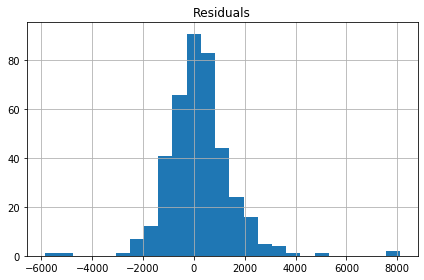

SVR train score 0.875, SVR Valid score: 0.882 



Regression statistics

                      Mean Error (ME) : 78.1283
       Root Mean Squared Error (RMSE) : 1308.1329
            Mean Absolute Error (MAE) : 900.7360
          Mean Percentage Error (MPE) : -0.9589
Mean Absolute Percentage Error (MAPE) : 7.8480

Regression statistics

                      Mean Error (ME) : 216.1840
       Root Mean Squared Error (RMSE) : 1308.5433
            Mean Absolute Error (MAE) : 910.9655
          Mean Percentage Error (MPE) : 0.0805
Mean Absolute Percentage Error (MAPE) : 7.8684


In [205]:
car_df = SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

car_df.fit(train_X, train_y)

car_df_pred = car_df.predict(valid_X)

result = pd.DataFrame({'Predicted': car_df_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_df_pred})
print(result.head(20))

# Compute common accuracy measures
car_df_pred = car_df.predict(valid_X)
all_residuals = valid_y - car_df_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Partition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

#Regression Stats and Model Score
print('SVR train score %.3f, SVR Valid score: %.3f \n\n' % 
      (car_df.score(train_X,train_y),
       car_df.score(valid_X, valid_y)))
regressionSummary(train_y, car_df.predict(train_X))
regressionSummary(valid_y, car_df.predict(valid_X))

# Logistic Regression

In [ ]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns

from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

### Import Dataset and Clean Data

In [ ]:
bank_df = pd.read_csv('UniversalBank.csv')
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]

# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories, inplace=True)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

### Losgistic Regression with no Regularization

In [ ]:
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

### Confusion Matrix

In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)

# Prediction for Train
classificationSummary(train_y, logit_reg.predict(train_X))
# Prediction for Valid
classificationSummary(valid_y, logit_reg.predict(valid_X))

In [ ]:
# use GLM (general linear model) with the binomial family to fit a logistic regression
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
print(logit_result.summary())

### Rerun with Pruned Predictors

In [ ]:
bank_df = pd.read_csv('UniversalBank.csv')
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]

# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories, inplace=True)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan', 'Mortgage'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

### Rerun Confusion Matrix

In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)

# Prediction for Train
classificationSummary(train_y, logit_reg.predict(train_X))
# Prediction for Valid
classificationSummary(valid_y, logit_reg.predict(valid_X))

In [ ]:
# use GLM (general linear model) with the binomial family to fit a logistic regression
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
print(logit_result.summary())

## Nominal Regression: Multiple Outcomes without Ordering

In [ ]:
data = pd.read_csv('accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
print('predictors', predictors)
print()
y = data[outcome]
X = data[predictors]
train_X, train_y = X, y
classes = sorted(y.unique())

logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)

print('intercept', logit.intercept_)
print('coef', logit.coef_)
print('classes', logit.classes_)

probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y,
    'predicted': logit.predict(X),
    'P(a)': [p[0] for p in probs],
    'P(b)': [p[1] for p in probs],
    'P(c)': [p[2] for p in probs],
})
print(results.head())
classificationSummary(y, results.predicted, class_names=classes)

### Nominal Regression: Statsmodel

In [ ]:
# same initial preprocessing and creating dummies
data = pd.read_csv('accidentsFull.csv')
data['MAX_SEV_IR'] = data['MAX_SEV_IR'].astype('category')

outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']

y = data[outcome]
X = data[predictors]
classes = sorted(y.unique())\

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# use GLM (general linear model) with the binomial family to fit a logistic regression
logit_model=sm.MNLogit(train_y,sm.add_constant(train_X))
logit_model
result=logit_model.fit()

stats1=result.summary()
stats2=result.summary2()
print(stats1)
print(stats2)

## Ordinal Logistic Regression: Multiple Outcomes with Ordering

In [ ]:
import random
from mord import LogisticIT

data = pd.read_csv('accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
y = data[outcome]
X = data[predictors]
X['ALCHL_I']
train_X, train_y = X, y
classes = sorted(y.unique())

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit = LogisticIT(alpha=0)
logit.fit(X, y)

print('theta', logit.theta_)
print('coef', logit.coef_)
print('classes', logit.classes_)
print()


probs = logit.predict_proba(X)

results = pd.DataFrame({
    'actual': [yi + random.gauss(0, 0.001) for yi in y],
    'predicted': logit.predict(X),
    'P(a)': [p[0] + random.gauss(0, 0.001) for p in probs],
    'P(b)': [p[1] + random.gauss(0, 0.001) for p in probs],
    'P(c)': [p[2] + random.gauss(0, 0.001) for p in probs],
})
print(results.head())

classificationSummary(y, results.predicted, class_names=classes)

### Ordinal Regression: Statsmodel

In [ ]:
endog = train_y
exog = train_X
groups = train_y

ind = sm.cov_struct.Independence()
model1 = sm.OrdinalGEE(endog, exog, groups, cov_struct=ind)
result1 = model1.fit()
result1.summary()

# Regression Tree

In [3]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.api as sm
from six import StringIO 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import matplotlib.pylab as plt
import seaborn as sns
import pydotplus
from graphviz import Graph

from dmba import plotDecisionTree, classificationSummary, regressionSummary

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

no display found. Using non-interactive Agg backend
D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


## Regression Tree: Exhaustive Grid Search for Hyperparameters

In [65]:
toyotaCorolla_df = pd.read_csv('ToyotaCorolla.csv').iloc[:1000,:]
toyotaCorolla_df = toyotaCorolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})

predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Tax', 'Weight']
outcome = 'Price'

X = pd.get_dummies(toyotaCorolla_df[predictors], drop_first=True)
y = toyotaCorolla_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# user grid search to find optimized tree
param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'min_samples_split': [10, 20, 30, 40, 50], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008], 
    'min_samples_split': [14, 15, 16, 18, 20, ], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

rt = gridSearch.best_estimator_

Initial score:  0.8415123291023757
Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 20}
Initial score:  0.848498758240526
Improved parameters:  {'max_depth': 6, 'min_impurity_decrease': 0, 'min_samples_split': 16}


   ### Regression Data

In [66]:
print('rt train score %.3f, rt test score: %.3f \n\n' % 
      (rt.score(train_X,train_y),
       rt.score(valid_X, valid_y)))
regressionSummary(train_y, rt.predict(train_X))
regressionSummary(valid_y, rt.predict(valid_X))

rt train score 0.918, rt test score: 0.834 



Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1058.8202
            Mean Absolute Error (MAE) : 767.7203
          Mean Percentage Error (MPE) : -0.8074
Mean Absolute Percentage Error (MAPE) : 6.8325

Regression statistics

                      Mean Error (ME) : 60.5241
       Root Mean Squared Error (RMSE) : 1554.9146
            Mean Absolute Error (MAE) : 1026.3487
          Mean Percentage Error (MPE) : -1.3082
Mean Absolute Percentage Error (MAPE) : 9.2311


        Predicted  Actual     Residual
507  11049.444444   11500   450.555556
818   9301.424658    8950  -351.424658
452  11318.800000   11450   131.200000
368  12455.000000   11450 -1005.000000
242  11261.842105   11950   688.157895
929   9301.424658    9995   693.575342
262  11261.842105   13500  2238.157895
810   8642.702703    7950  -692.702703
318  11261.842105    9900 -1361.842105
49   21760.000000   21950   190.000000
446  10923.823529   11950  1026.176471
142  23768.461538   19950 -3818.461538
968  10491.923077    9950  -541.923077
345  12378.095238   14950  2571.904762
971   9301.424658   10495  1193.575342
133  16338.076923   15950  -388.076923
104  23768.461538   19450 -4318.461538
6    17233.333333   16900  -333.333333
600  11318.800000   11250   -68.800000
496  10923.823529   11750   826.176471

Regression statistics

                      Mean Error (ME) : 60.5241
       Root Mean Squared Error (RMSE) : 1554.9146
            Mean Absolute Error (MAE) : 1026.3487
         

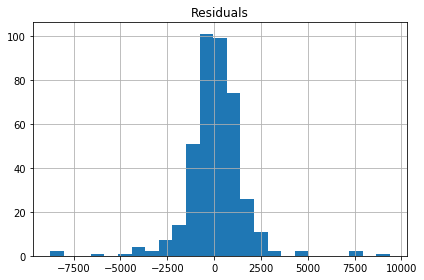

In [67]:
rt = rt.predict(valid_X)

result = pd.DataFrame({'Predicted': rt, 'Actual': valid_y,
                       'Residual': valid_y - rt})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, rt)

all_residuals = valid_y - rt

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Partition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

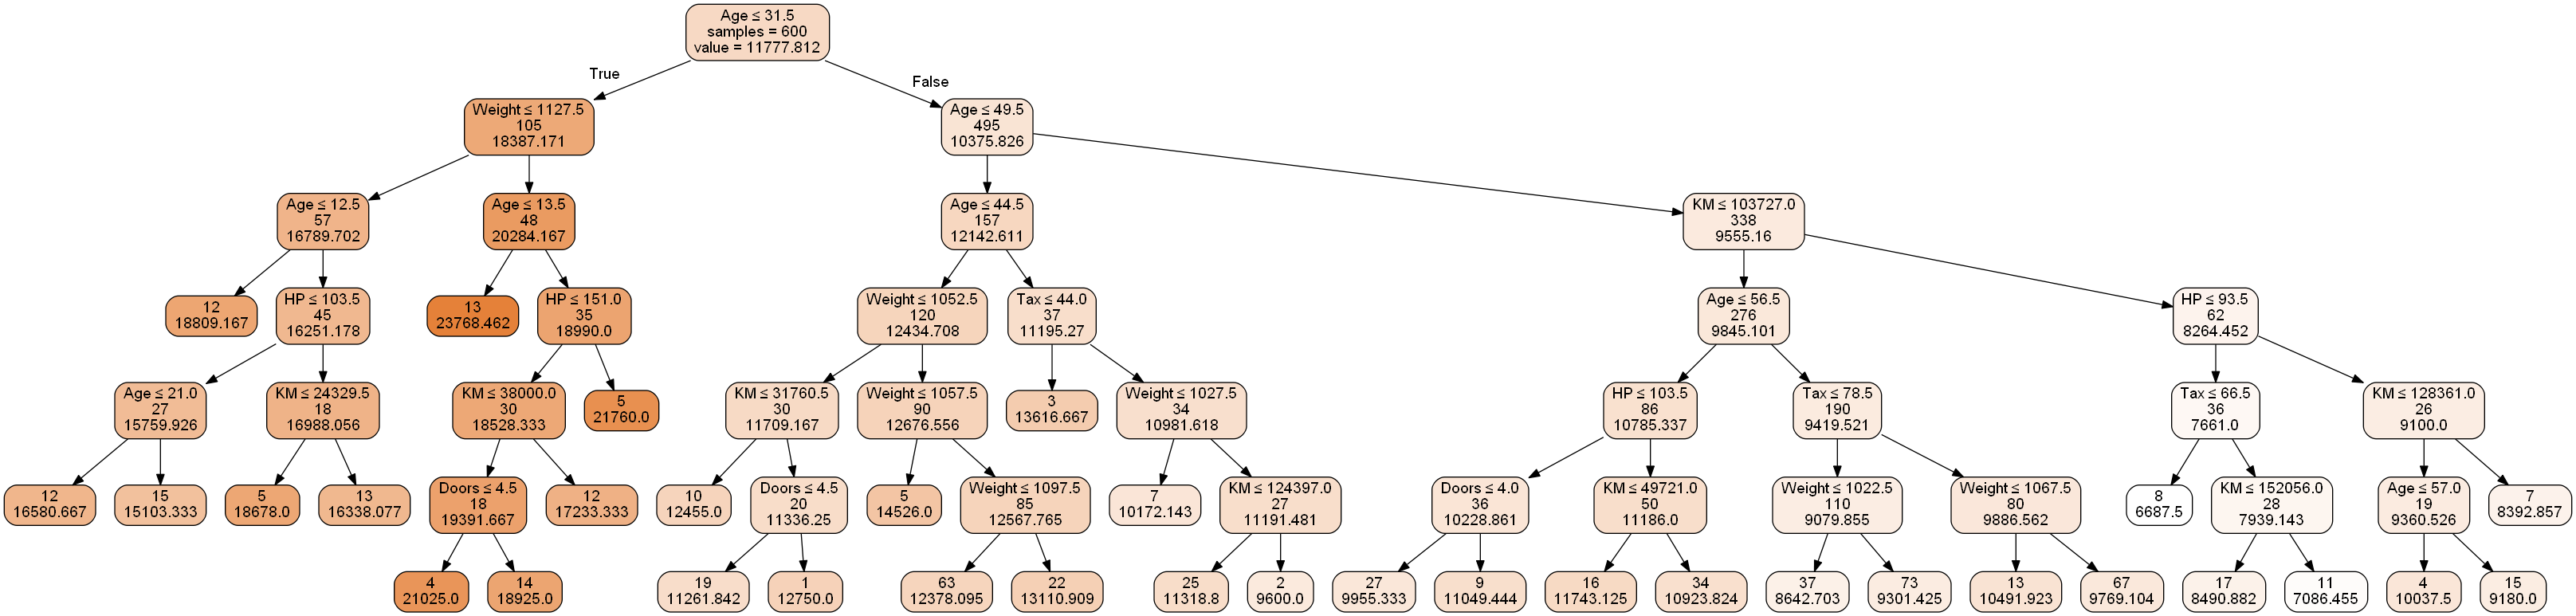

In [34]:
plotDecisionTree(rf, feature_names=train_X.columns)

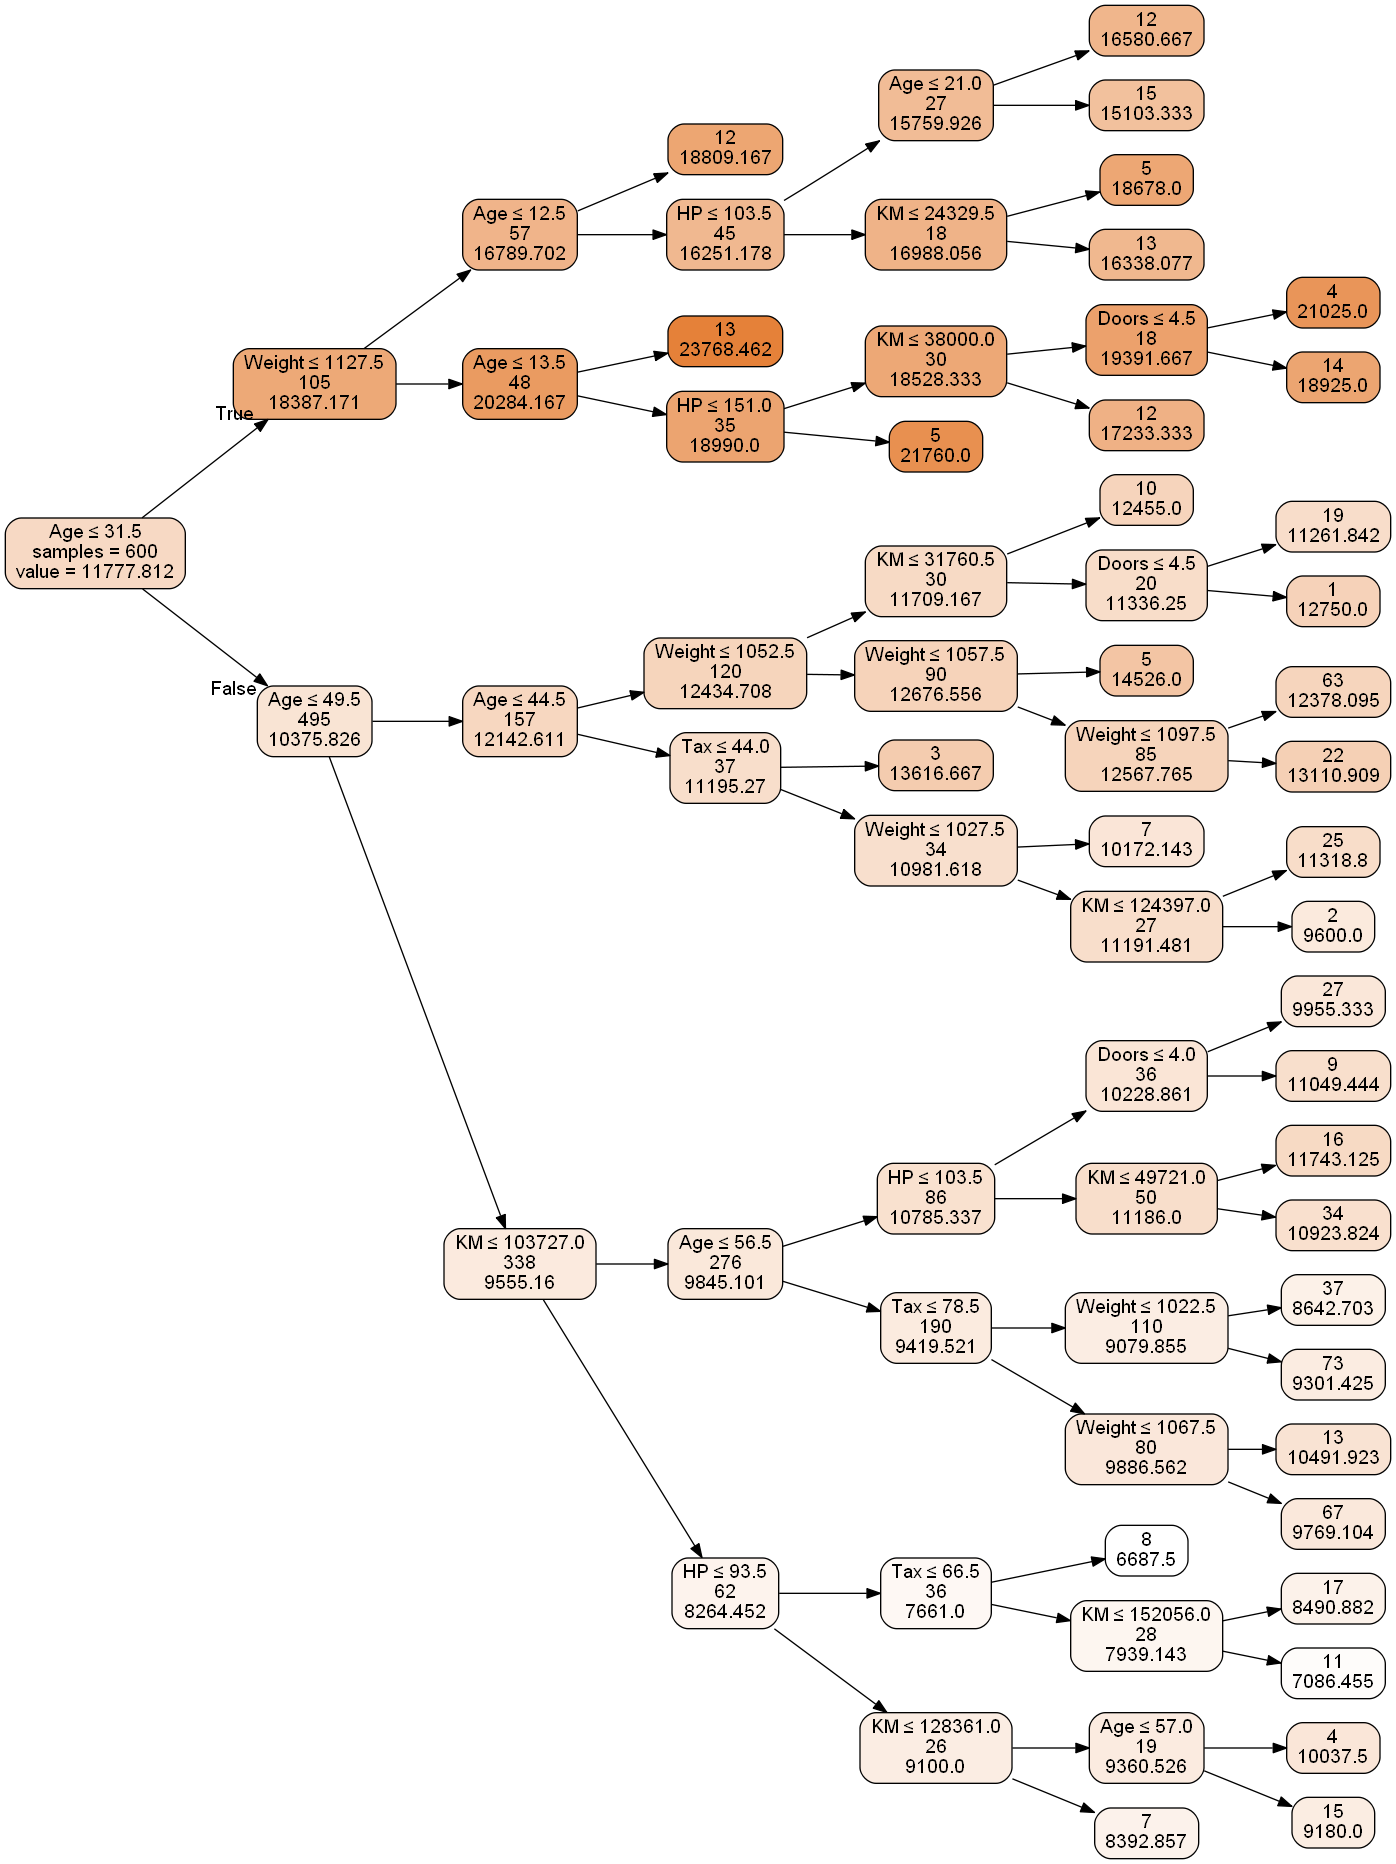

In [35]:
plotDecisionTree(rf, feature_names=train_X.columns, rotate=True)

# Random Forest Regression

In [119]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.api as sm

from six import StringIO
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import matplotlib.pylab as plt
import seaborn as sns
import pydotplus
from graphviz import Graph

from dmba import plotDecisionTree, classificationSummary, regressionSummary

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


## Initial GridSearch Parameters

In [125]:
toyotaCorolla_df = pd.read_csv('ToyotaCorolla.csv').iloc[:1000,:]
toyotaCorolla_df = toyotaCorolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})

predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Tax', 'Weight']
outcome = 'Price'

X = pd.get_dummies(toyotaCorolla_df[predictors], drop_first=True)
y = toyotaCorolla_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

rf = RandomForestRegressor(random_state=2)

#Initial Parameters
random_grid_rf = dict(n_estimators=[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                     max_features=['auto', 'sqrt'],
                     max_depth=[int(x) for x in np.linspace(10, 110, num = 11)],
                     min_samples_split=[10, 20, 30, 40, 50],
                     min_samples_leaf= np.arange(1, 15, 2),
                     bootstrap=[True, False],
                     oob_score=[False, ])

gridSearch = RandomizedSearchCV(random_state= 4, estimator = rf, param_distributions = random_grid_rf, n_iter = 100, cv = 3, n_jobs = -1)
gridSearch.fit(train_X, train_y)
print('\n\n Initial score: ', gridSearch.best_score_)
gridSearch.best_params_



 Initial score:  0.8801814991781495


{'oob_score': False,
 'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

## Tuned GridSearch Parameters

In [128]:
#Initial Parameters
random_grid_rf = dict(n_estimators=[int(x) for x in np.linspace(start = 700, stop = 900, num = 5)],
                     max_features=['auto'],
                     max_depth=list(range(60, 80, 1)),
                     min_samples_split=list(range(10, 20, 1)),
                     min_samples_leaf= [1, 2, 3, 4, 5],
                     bootstrap=[True],
                     oob_score=[False])

gridSearch = RandomizedSearchCV(random_state= 4, estimator = rf, param_distributions = random_grid_rf, n_iter = 100, cv = 3, n_jobs = -1)
gridSearch.fit(train_X, train_y)
print("\n The best estimator across ALL searched params:\n",
      gridSearch.best_estimator_)
print('\n\n Best Train Score: ', gridSearch.best_score_)
gb = gridSearch.best_params_


 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=76, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)


 Best Train Score:  0.8801814991781495


### Residual Histogram for Valid Partition

        Predicted  Actual     Residual
507  10937.301183   11500   562.698817
818   9521.907665    8950  -571.907665
452  11141.911556   11450   308.088444
368  12679.859067   11450 -1229.859067
242  11720.985769   11950   229.014231
929  10241.479942    9995  -246.479942
262  11572.435365   13500  1927.564635
810   9289.503268    7950 -1339.503268
318  11381.764347    9900 -1481.764347
49   20026.907191   21950  1923.092809
446  11288.780135   11950   661.219865
142  21251.820878   19950 -1301.820878
968  10187.179186    9950  -237.179186
345  12486.184866   14950  2463.815134
971   9289.536353   10495  1205.463647
133  16625.924175   15950  -675.924175
104  21875.471571   19450 -2425.471571
6    17914.253865   16900 -1014.253865
600  11757.698785   11250  -507.698785
496  10758.205013   11750   991.794987

Regression statistics

                      Mean Error (ME) : 59.3642
       Root Mean Squared Error (RMSE) : 1320.1816
            Mean Absolute Error (MAE) : 904.1445
          

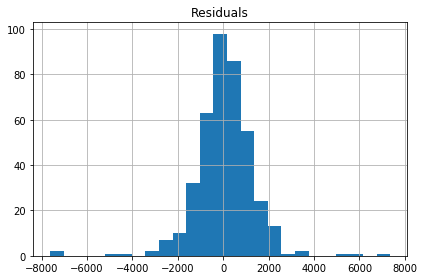

rf Train score 0.955, rf Valid score: 0.880 




In [129]:
rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=76, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

rf.fit(train_X, train_y)

pred = rf.predict(valid_X)

result = pd.DataFrame({'Predicted': pred, 'Actual': valid_y,
                       'Residual': valid_y - pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, pred)

all_residuals = valid_y - pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Parfition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)


plt.tight_layout()
plt.show()
print('rf Train score %.3f, rf Valid score: %.3f \n\n' % 
      (rf.score(train_X,train_y),
       rf.score(valid_X, valid_y)))

# Gradient Boosted Regression Tree

In [118]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.api as sm

from six import StringIO
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from scipy.stats import StringIO as sp_randString

import matplotlib.pylab as plt
import seaborn as sns
import pydotplus
from graphviz import Graph

from dmba import plotDecisionTree, classificationSummary, regressionSummary

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

ImportError: cannot import name 'StringIO' from 'scipy.stats' (C:\Users\LaoTz\Anaconda3\lib\site-packages\scipy\stats\__init__.py)

## RandomSearch Parameter Tuning

In [68]:
toyotaCorolla_df = pd.read_csv('ToyotaCorolla.csv').iloc[:1000,:]
toyotaCorolla_df = toyotaCorolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})

predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Tax', 'Weight']
outcome = 'Price'

X = pd.get_dummies(toyotaCorolla_df[predictors], drop_first=True)
y = toyotaCorolla_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

gb = GradientBoostingRegressor(random_state=2)
parameters = {'learning_rate': sp_randFloat(),
              'subsample'    : sp_randFloat(),
              'n_estimators' : sp_randInt(100, 1000),
              'max_depth'    : sp_randInt(4, 30),
              'max_features' : sp_randFloat(),
              'ccp_alpha'    : sp_randFloat(),
              'alpha'        : sp_randFloat(),
              'loss'         :['ls', 'lad', 'huber', 'quantile']
              }
    
gridSearch = RandomizedSearchCV(estimator=gb, param_distributions = parameters, 
                               cv = 5, n_iter = 30, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print("\n The best estimator across ALL searched params:\n",
      gridSearch.best_estimator_)
print('\n\n Best Train Score: ', gridSearch.best_score_)
gb = gridSearch.best_params_


 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.2587923967826117,
                          ccp_alpha=0.21814080088105603,
                          criterion='friedman_mse', init=None,
                          learning_rate=0.1468051131263053, loss='ls',
                          max_depth=19, max_features=0.5291412064355725,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=202, n_iter_no_change=None,
                          presort='deprecated', random_state=2,
                          subsample=0.9780229535330371, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


 Best Score:  0.8726758422791739


### Residual Histogram for Valid Partition

        Predicted  Actual     Residual
507  11305.149108   11500   194.850892
818   9900.682242    8950  -950.682242
452  11390.179952   11450    59.820048
368  13202.083354   11450 -1752.083354
242  11273.693414   11950   676.306586
929   9748.356310    9995   246.643690
262  11190.835227   13500  2309.164773
810   8979.737770    7950 -1029.737770
318  11206.074634    9900 -1306.074634
49   20694.183531   21950  1255.816469
446  11225.963903   11950   724.036097
142  22661.247388   19950 -2711.247388
968  10063.131749    9950  -113.131749
345  12579.938897   14950  2370.061103
971   9242.845380   10495  1252.154620
133  16500.264610   15950  -550.264610
104  21487.262231   19450 -2037.262231
6    17763.713415   16900  -863.713415
600  12339.096691   11250 -1089.096691
496  10866.851830   11750   883.148170

Regression statistics

                      Mean Error (ME) : 20.7200
       Root Mean Squared Error (RMSE) : 1294.8341
            Mean Absolute Error (MAE) : 949.3812
          

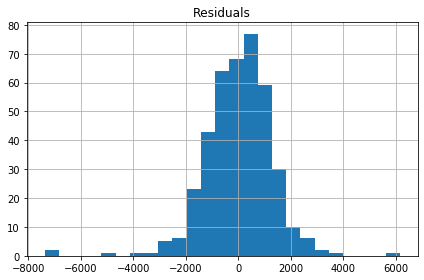

GB Train score 1.000, GB Valid score: 0.885 




In [101]:
gb = GradientBoostingRegressor(alpha=0.2587923967826117,
                          ccp_alpha=0.21814080088105603,
                          criterion='friedman_mse', init=None,
                          learning_rate=0.1468051131263053, loss='ls',
                          max_depth=19, max_features=0.5291412064355725,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=202, n_iter_no_change=None,
                          presort='deprecated', random_state=2,
                          subsample=0.9780229535330371, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

gb.fit(train_X, train_y)

pred = gb.predict(valid_X)

result = pd.DataFrame({'Predicted': pred, 'Actual': valid_y,
                       'Residual': valid_y - pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, pred)

all_residuals = valid_y - pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Pagbition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)


plt.tight_layout()
plt.show()
print('GB Train score %.3f, GB Valid score: %.3f \n\n' % 
      (gb.score(train_X,train_y),
       gb.score(valid_X, valid_y)))

GB Train score 1.000, GB Valid score: 0.885 



Regression statistics

                      Mean Error (ME) : 0.0216
       Root Mean Squared Error (RMSE) : 5.6048
            Mean Absolute Error (MAE) : 4.6307
          Mean Percentage Error (MPE) : -0.0048
Mean Absolute Percentage Error (MAPE) : 0.0432

Regression statistics

                      Mean Error (ME) : 20.7200
       Root Mean Squared Error (RMSE) : 1294.8341
            Mean Absolute Error (MAE) : 949.3812
          Mean Percentage Error (MPE) : -1.2767
Mean Absolute Percentage Error (MAPE) : 8.9634


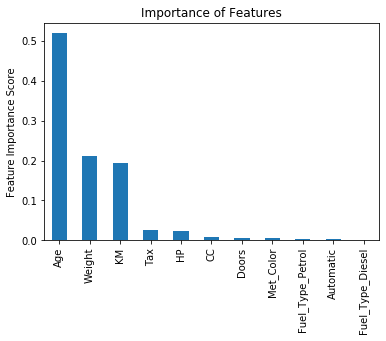

In [103]:
gb = GradientBoostingRegressor(alpha=0.2587923967826117,
                          ccp_alpha=0.21814080088105603,
                          criterion='friedman_mse', init=None,
                          learning_rate=0.1468051131263053, loss='ls',
                          max_depth=19, max_features=0.5291412064355725,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=202, n_iter_no_change=None,
                          presort='deprecated', random_state=2,
                          subsample=0.9780229535330371, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

gb.fit(train_X, train_y)

importances = gb.feature_importances_
predictors=list(train_X)
feat_imp = pd.Series(gb.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
pred=gb.predict(valid_X)
print('GB Train score %.3f, GB Valid score: %.3f \n\n' % 
      (gb.score(train_X,train_y),
       gb.score(valid_X, valid_y)))
regressionSummary(train_y, gb.predict(train_X))
regressionSummary(valid_y, gb.predict(valid_X))

# Classification Tree

In [5]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.api as sm

from six import StringIO
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import matplotlib.pylab as plt
import seaborn as sns
import pydotplus
from graphviz import Graph

from dmba import plotDecisionTree, classificationSummary, regressionSummary

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


### Full Tree

In [ ]:
bank_df = pd.read_csv('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X, train_y)

#Number of Nodes
tree = fullClassTree
print('Number of nodes', tree.tree_.node_count)

plotDecisionTree(fullClassTree, feature_names=train_X.columns)

#### Confusion Matrix (over fitted)

In [ ]:
print('train score %.3f, dt test score: %.3f \n\ndt' % (
fullClassTree.score(train_X,train_y),
fullClassTree.score(valid_X, valid_y)))
classificationSummary(train_y, fullClassTree.predict(train_X))
classificationSummary(valid_y, fullClassTree.predict(valid_X))

### Pruned Tree

In [ ]:
smallClassTree = DecisionTreeClassifier(max_depth=30, min_samples_split=20, min_impurity_decrease=0.01) #impurity = CP in Rpart
smallClassTree.fit(train_X, train_y)

tree = smallClassTree
print('Number of nodes', tree.tree_.node_count)

plotDecisionTree(smallClassTree, feature_names=train_X.columns)

#### Confusion Matrix

In [ ]:
print('train score %.3f, dt test score: %.3f \n\ndt' % (
smallClassTree.score(train_X,train_y),
smallClassTree.score(valid_X, valid_y)))

classificationSummary(train_y, smallClassTree.predict(train_X))
classificationSummary(valid_y, smallClassTree.predict(valid_X))

### Pruned Tree: Exhaustive Grid Search for Hyperparameters

In [116]:
bank_df = pd.read_csv('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.9876666666666667
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [111]:
# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 16)), 
    'min_samples_split': list(range(10, 22)), 
    'min_impurity_decrease': [0.0009, 0.001, 0.0011], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

print("\n The best estimator across ALL searched params:\n",
      gridSearch.best_estimator_)
print('\n\n Best Train Score: ', gridSearch.best_score_)
bestClassTree = gridSearch.best_estimator_

Improved score:  0.9873333333333333
Improved parameters:  {'max_depth': 4, 'min_impurity_decrease': 0.0011, 'min_samples_split': 13}

 The best estimator across ALL searched params:
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0011, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


 Best Train Score:  0.9873333333333333


#### Best Tree Plotted

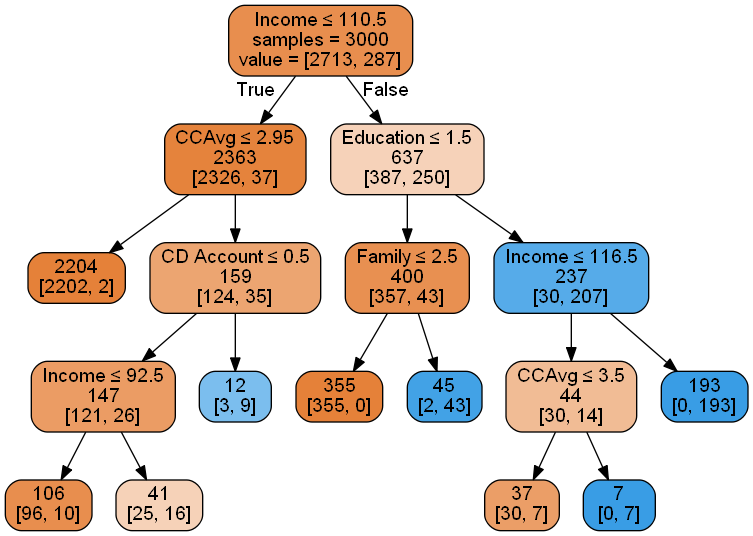

In [112]:
plotDecisionTree(bestClassTree, feature_names=train_X.columns)

In [113]:
print('dt train score %.3f, dt test score: %.3f \n\n' % 
      (bestClassTree.score(train_X,train_y),
       bestClassTree.score(valid_X, valid_y)))
classificationSummary(train_y, bestClassTree.predict(train_X))
classificationSummary(valid_y, bestClassTree.predict(valid_X))

dt train score 0.987, dt test score: 0.982 


Confusion Matrix (Accuracy 0.9867)

       Prediction
Actual    0    1
     0 2708    5
     1   35  252
Confusion Matrix (Accuracy 0.9815)

       Prediction
Actual    0    1
     0 1801    6
     1   31  162


# Random Forest Classification Tree

In [104]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.api as sm

from six import StringIO
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import matplotlib.pylab as plt
import seaborn as sns
import pydotplus
from graphviz import Graph

from dmba import plotDecisionTree, classificationSummary, regressionSummary

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


## Initial GridSearch Parameters

In [105]:
bank_df = pd.read_csv('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

rf = RandomForestClassifier()

#Initial Parameters
random_grid_rf = dict(n_estimators=[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                     max_features=['auto', 'sqrt'],
                     max_depth=[int(x) for x in np.linspace(10, 110, num = 11)],
                     min_samples_split=[10, 20, 30, 40, 50],
                     min_samples_leaf= np.arange(1, 15, 2),
                     bootstrap=[True, False],
                     oob_score=[False, ])

gridSearch = RandomizedSearchCV(estimator = rf, param_distributions = random_grid_rf, n_iter = 100, cv = 3, n_jobs = -1)
gridSearch.fit(train_X, train_y)
print('\n\n Initial score: ', gridSearch.best_score_)
gridSearch.best_params_

KeyboardInterrupt: 

## Tune GridSearch Parameters

In [107]:
# Adapt grid based on result from initial grid search
random_grid_rf = dict(n_estimators=[1600],
                     max_features=['auto'],
                     max_depth=[25,26,27,28,29,30,31,32,33,34,35],
                     min_samples_split=[5,6,7,8,9,10,11,12,13,14,15],
                     min_samples_leaf= list(range(1,5)),
                     bootstrap=[False],
                     oob_score=[False])

gridSearch = RandomizedSearchCV(estimator = rf, param_distributions = random_grid_rf, 
                                n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

gridSearch.fit(train_X, train_y)
print("\n The best estimator across ALL searched params:\n",
      gridSearch.best_estimator_)
print('\n\n Best Train Score: ', gridSearch.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.3s finished



 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=35, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


 Best Train Score:  0.9896666666666666


{'oob_score': False,
 'n_estimators': 1600,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 35,
 'bootstrap': False}

### Variable Importance Plot

               feature  importance       std
7   Securities Account    0.003185  0.004218
9               Online    0.003278  0.003854
10          CreditCard    0.005391  0.005978
1           Experience    0.022606  0.010428
0                  Age    0.024373  0.011242
6             Mortgage    0.026726  0.020462
8           CD Account    0.061469  0.043913
3               Family    0.117694  0.058757
4                CCAvg    0.172166  0.112597
5            Education    0.217039  0.105386
2               Income    0.346072  0.133238


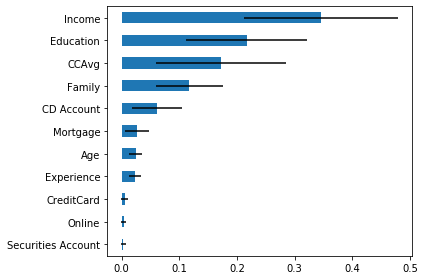

In [108]:
rf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=35, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf.fit(train_X, train_y)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({
    'feature': train_X.columns,
    'importance': importances,
    'std': std
})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

### Confusion Matrix

In [109]:
print('dt train score %.3f, dt test score: %.3f \n\n' % 
      (rf.score(train_X,train_y),
       rf.score(valid_X, valid_y)))
classificationSummary(train_y, rf.predict(train_X))
classificationSummary(valid_y, rf.predict(valid_X))

dt train score 0.999, dt test score: 0.984 


Confusion Matrix (Accuracy 0.9993)

       Prediction
Actual    0    1
     0 2713    0
     1    2  285
Confusion Matrix (Accuracy 0.9835)

       Prediction
Actual    0    1
     0 1802    5
     1   28  165


# Gradient Boosted Classification

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.api as sm   

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


## Initial Hyper Parameters

In [9]:
bank_df = pd.read_csv('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

gb = GradientBoostingClassifier(random_state=2)
parameters = {'learning_rate': sp_randFloat(),
              'subsample'    : sp_randFloat(),
              'n_estimators' : sp_randInt(100, 1000),
              'max_depth'    : sp_randInt(4, 10) 
                 }
    
gridSearch = RandomizedSearchCV(estimator=gb, param_distributions = parameters, 
                               cv = 5, n_iter = 10, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('\n\n Initial score: ', gridSearch.best_score_)
gridSearch.best_params_


 The best estimator across ALL searched params:
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.052610036795373905, loss='deviance',
                           max_depth=9, max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=880,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2, subsample=0.4914442352107561,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)


 Best Score:  0.9879999999999999


{'learning_rate': 0.052610036795373905,
 'max_depth': 9,
 'n_estimators': 880,
 'subsample': 0.4914442352107561}

## Tuned Parameters

In [ ]:
parameters = {'learning_rate': sp_randFloat(),
              'subsample'    : sp_randFloat(),
              'n_estimators' : sp_randInt(100, 1000),
              'max_depth'    : sp_randInt(4, 10) 
                 }
    
gridSearch = RandomizedSearchCV(estimator=gb, param_distributions = parameters, 
                               cv = 5, n_iter = 10, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print("\n The best estimator across ALL searched params:\n",
      gridSearch.best_estimator_)
print('\n\n Best Score: ', gridSearch.best_score_)
gridSearch.best_params_

### Importance Plot

Accuracy of the GBM on Valid set: 0.983
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1807
           1       0.96      0.86      0.91       193

    accuracy                           0.98      2000
   macro avg       0.97      0.93      0.95      2000
weighted avg       0.98      0.98      0.98      2000



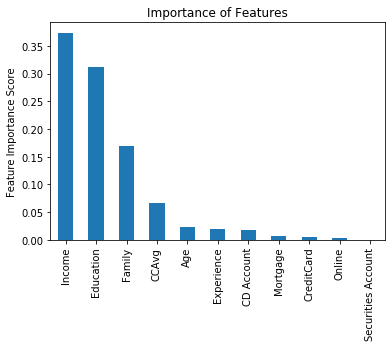

In [108]:
from sklearn.metrics import classification_report

rf =  GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.353311986908719, loss='deviance',
                           max_depth=6, max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=156,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.7999428424932169,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)
rf.fit(train_X, train_y)

importances = rf.feature_importances_
predictors=list(train_X)
feat_imp = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on Valid set: {:.3f}'.format(rf.score(valid_X, valid_y)))
pred=rf.predict(valid_X)
print(classification_report(valid_y, pred))

### Confusion Matrix

In [109]:
print('dt train score %.3f, dt test score: %.3f \n\n' % 
      (rf.score(train_X,train_y),
       rf.score(valid_X, valid_y)))
classificationSummary(train_y, rf.predict(train_X))
classificationSummary(valid_y, rf.predict(valid_X))

dt train score 1.000, dt test score: 0.983 


Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2713    0
     1    0  287
Confusion Matrix (Accuracy 0.9830)

       Prediction
Actual    0    1
     0 1800    7
     1   27  166


# Neural Network Classification

In [44]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from dmba import classificationSummary
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from scipy import stats

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


## Low Complexity Classification NN

In [100]:
example_df = pd.read_csv('TinyData.csv')

predictors = ['Fat', 'Salt']
outcome = 'Acceptance'

X = example_df[predictors]
y = example_df[outcome]
classes = sorted(y.unique())

clf = MLPClassifier(hidden_layer_sizes=(3), activation='logistic', solver='lbfgs', random_state=1)
clf.fit(X, y)
clf.predict(X)

# Network structure
print('Intercepts')
print(clf.intercepts_)

print('Weights')
print(clf.coefs_)

# Prediction
print(pd.concat([
    example_df,
    pd.DataFrame(clf.predict_proba(X), columns=classes)
], axis=1))

Intercepts
[array([0.13368045, 4.07247552, 7.00768104]), array([14.30748677])]
Weights
[array([[ -1.30656481,  -4.20427791, -13.29587332],
       [ -0.04399727,  -4.91606924,  -6.03356987]]), array([[ -0.27348313],
       [ -9.01211572],
       [-17.63504696]])]
   Obs.  Fat  Salt Acceptance   dislike      like
0     1  0.2   0.9       like  0.000490  0.999510
1     2  0.1   0.1    dislike  0.999994  0.000006
2     3  0.2   0.4    dislike  0.999741  0.000259
3     4  0.2   0.5    dislike  0.997368  0.002632
4     5  0.4   0.5       like  0.002133  0.997867
5     6  0.3   0.8       like  0.000075  0.999925


### Weights and Intercepts

In [101]:
for i, (weights, intercepts) in enumerate(zip(clf.coefs_, clf.intercepts_)):
    print('Hidden layer' if i == 0 else 'Output layer', '{0[0]} => {0[1]}'.format(weights.shape))
    print(' Intercepts:\n ', intercepts)
    print(' Weights:')
    for weight in weights:
        print(' ', weight)
    print()

Hidden layer 2 => 3
 Intercepts:
  [0.13368045 4.07247552 7.00768104]
 Weights:
  [ -1.30656481  -4.20427791 -13.29587332]
  [-0.04399727 -4.91606924 -6.03356987]

Output layer 3 => 1
 Intercepts:
  [14.30748677]
 Weights:
  [-0.27348313]
  [-9.01211572]
  [-17.63504696]



### Confusion Matrix

In [102]:
classificationSummary(y, clf.predict(X), class_names=classes)

Confusion Matrix (Accuracy 1.0000)

        Prediction
 Actual dislike    like
dislike       3       0
   like       0       3


## Higher Complexity Classification NN

In [52]:
accidents_df = pd.read_csv('accidentsnn.csv')
input_vars = ['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL']

accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')

# convert the categorical data into dummy variables
processed = pd.get_dummies(accidents_df)
# drop the column for SUR_COND 9 = unknown
processed = processed.drop(columns=['SUR_COND_9'])

outcome = ['MAX_SEV_IR_0', 'MAX_SEV_IR_1', 'MAX_SEV_IR_2']
predictors = [c for c in processed.columns if c not in outcome]
classes = sorted(outcome)

# partition data
X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs',
                    random_state=1)
clf.fit(train_X, train_y.values)

C:\Users\LaoTz\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=2, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [53]:
# training performance (use idxmax to revert the one-hot-encoding)
trainPrediction = pd.DataFrame(clf.predict(train_X), columns=outcome).idxmax(axis=1)
classificationSummary(train_y.idxmax(axis=1), trainPrediction, class_names=classes)

# validation performance
validPrediction = pd.DataFrame(clf.predict(valid_X), columns=outcome).idxmax(axis=1)
classificationSummary(valid_y.idxmax(axis=1), validPrediction, class_names=classes)

Confusion Matrix (Accuracy 0.8731)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          332            0            0
MAX_SEV_IR_1            0          170           10
MAX_SEV_IR_2           31           35           21
Confusion Matrix (Accuracy 0.8675)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          218            0            1
MAX_SEV_IR_1            0          113            6
MAX_SEV_IR_2           24           22           16


### Search Parameters for a Better Model

In [49]:
param_grid = {
    'hidden_layer_sizes': [(1,1,1), (2,1,2), (3,1,3), (4,1,4), (5,1,5),
                           (1,2,1), (2,2,2), (3,2,3), (4,2,4), (5,2,5),
                          (1,3,1), (2,3,2), (3,3,3), (4,3,4), (5,3,5),
                          (1,4,1), (2,4,2), (3,4,3), (4,4,4), (5,4,5),
                          (1,5,1), (2,5,2), (3,5,3), (4,5,4), (5,5,5)],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'solver' : ['lbfgs', 'sgd', 'adam'],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init' : [.001, .0,1, .1, 1],
    'early_stopping': [True],
    
}
gridSearch = GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1), 
                          param_grid, cv=5, n_jobs=-1, return_train_score=True)
gridSearch.fit(train_X, train_y)
print("\n The best estimator across ALL searched params:\n",
      gridSearch.best_estimator_)
print('\n\n Best Score: ', gridSearch.best_score_)
gridSearch.best_params_


 The best estimator across ALL searched params:
 MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(3, 1, 3), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


 Best Score:  0.8647619047619047


C:\Users\LaoTz\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'activation': 'tanh',
 'early_stopping': True,
 'hidden_layer_sizes': (3, 1, 3),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'solver': 'lbfgs'}

In [50]:
# training performance (use idxmax to revert the one-hot-encoding)
trainPrediction = pd.DataFrame(gridSearch.predict(train_X), columns=outcome).idxmax(axis=1)
classificationSummary(train_y.idxmax(axis=1), trainPrediction, class_names=classes)

# validation performance
validPrediction = pd.DataFrame(gridSearch.predict(valid_X), columns=outcome).idxmax(axis=1)
classificationSummary(valid_y.idxmax(axis=1), validPrediction, class_names=classes)

Confusion Matrix (Accuracy 0.8765)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          332            0            0
MAX_SEV_IR_1            0          172            8
MAX_SEV_IR_2           31           35           21
Confusion Matrix (Accuracy 0.8700)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          218            0            1
MAX_SEV_IR_1            0          114            5
MAX_SEV_IR_2           24           22           16


In [72]:
display=['param_hidden_layer_sizes', 'mean_test_score', 'std_test_score']
print(pd.DataFrame(gridSearch.cv_results_)[display])

     param_hidden_layer_sizes  mean_test_score  std_test_score
0                   (1, 1, 1)         0.480406        0.225133
1                   (1, 1, 1)         0.000000        0.000000
2                   (1, 1, 1)         0.000000        0.000000
3                   (1, 1, 1)              NaN             NaN
4                   (1, 1, 1)              NaN             NaN
...                       ...              ...             ...
4495                (5, 5, 5)         0.853095        0.018651
4496                (5, 5, 5)         0.853095        0.018651
4497                (5, 5, 5)         0.833095        0.038579
4498                (5, 5, 5)         0.554258        0.028627
4499                (5, 5, 5)         0.554258        0.028627

[4500 rows x 3 columns]


C:\Users\LaoTz\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


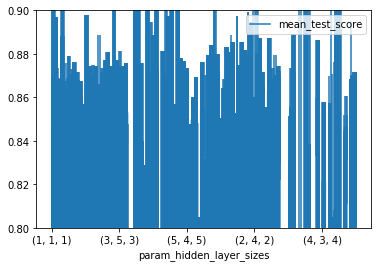

In [73]:
pd.DataFrame(gridSearch.cv_results_)[display].plot(x='param_hidden_layer_sizes', 
                                                   y='mean_test_score', yerr='std_test_score', ylim=(0.8, 0.9))

In [90]:
accidents_df = pd.read_csv('accidentsnn.csv')
input_vars = ['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL']

accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')

# convert the categorical data into dummy variables
processed = pd.get_dummies(accidents_df)
# drop the column for SUR_COND 9 = unknown
processed = processed.drop(columns=['SUR_COND_9'])

outcome = ['MAX_SEV_IR_0', 'MAX_SEV_IR_1', 'MAX_SEV_IR_2']
predictors = [c for c in processed.columns if c not in outcome]
classes = sorted(outcome)

# partition data
X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs',
                    random_state=1)
clf.fit(train_X, train_y.values)

param_grid = {
    'hidden_layer_sizes': [(1), (2), (3), (4), (5),
                           (1,1), (2,1), (3,1), (4,1), (5,1),
                           (1,2), (2,2), (3,2), (4,2), (5,2),
                          (1,3), (2,3), (3,3), (4,3), (5,3),
                          (1,4), (2,4), (3,4), (4,4), (5,4),
                          (1,5), (2,5), (3,5), (4,5), (5,5),
                           (1,1,1), (2,1,2), (3,1,3), (4,1,4), (5,1,5),
                           (1,2,1), (2,2,2), (3,2,3), (4,2,4), (5,2,5),
                          (1,3,1), (2,3,2), (3,3,3), (4,3,4), (5,3,5),
                          (1,4,1), (2,4,2), (3,4,3), (4,4,4), (5,4,5),
                          (1,5,1), (2,5,2), (3,5,3), (4,5,4), (5,5,5)],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'solver' : ['lbfgs', 'sgd', 'adam'],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init' : stats.uniform(0.001, 1),
    'early_stopping': [True],
    
}
gridSearch = RandomizedSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1), 
                          param_grid, n_iter=500, cv=5, n_jobs=-1, return_train_score=True)
gridSearch.fit(train_X, train_y)
print("\n The best estimator across ALL searched params:\n",
      gridSearch.best_estimator_)
print('\n\n Best Score: ', gridSearch.best_score_)
gridSearch.best_params_

C:\Users\LaoTz\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



 The best estimator across ALL searched params:
 MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(3, 1, 3), learning_rate='constant',
              learning_rate_init=0.33665182522736514, max_fun=15000,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)


 Best Score:  0.8647619047619047


C:\Users\LaoTz\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'activation': 'tanh',
 'early_stopping': True,
 'hidden_layer_sizes': (3, 1, 3),
 'learning_rate': 'constant',
 'learning_rate_init': 0.33665182522736514,
 'solver': 'lbfgs'}

In [91]:
# training performance (use idxmax to revert the one-hot-encoding)
trainPrediction = pd.DataFrame(gridSearch.predict(train_X), columns=outcome).idxmax(axis=1)
classificationSummary(train_y.idxmax(axis=1), trainPrediction, class_names=classes)

# validation performance
validPrediction = pd.DataFrame(gridSearch.predict(valid_X), columns=outcome).idxmax(axis=1)
classificationSummary(valid_y.idxmax(axis=1), validPrediction, class_names=classes)

Confusion Matrix (Accuracy 0.8765)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          332            0            0
MAX_SEV_IR_1            0          172            8
MAX_SEV_IR_2           31           35           21
Confusion Matrix (Accuracy 0.8700)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          218            0            1
MAX_SEV_IR_1            0          114            5
MAX_SEV_IR_2           24           22           16


In [92]:
display=['param_hidden_layer_sizes', 'mean_test_score', 'std_test_score']
print(pd.DataFrame(gridSearch.cv_results_)[display])

    param_hidden_layer_sizes  mean_test_score  std_test_score
0                  (3, 4, 3)         0.584258        0.040792
1                  (1, 3, 1)         0.554258        0.028627
2                     (1, 2)         0.854762        0.018672
3                  (3, 1, 3)         0.669762        0.152423
4                     (4, 1)         0.614258        0.117084
..                       ...              ...             ...
495                (1, 4, 1)         0.554258        0.028627
496                   (2, 3)         0.818025        0.024410
497                (3, 2, 3)         0.554258        0.028627
498                (2, 3, 2)         0.554258        0.028627
499                (5, 2, 5)         0.836429        0.014178

[500 rows x 3 columns]


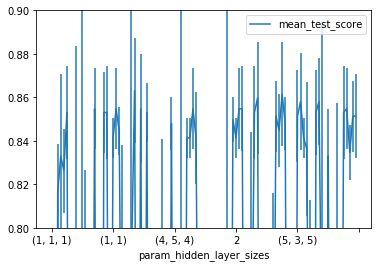

In [88]:
pd.DataFrame(gridSearch.cv_results_)[display].plot(x='param_hidden_layer_sizes', 
                                                   y='mean_test_score', yerr='std_test_score', ylim=(0.8, 0.9))

# Neural Network Regression

In [23]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from dmba import regressionSummary
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from scipy import stats

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


### Load Data and Process Data

In [24]:
car_df = pd.read_csv('ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000]

car_df.drop(columns=['Id', 'Model'], inplace=True)
car_df['Doors'] = car_df['Doors'].astype('category')
new_categories = {2: 'Sport', 3: 'SportHatch', 4: 'Sedan', 5: 'Hatch'}
car_df.Doors.cat.rename_categories(new_categories, inplace=True)
car_df = pd.get_dummies(car_df, drop_first=True)

### Convert Data Types to Integer

In [25]:
car_df = car_df.astype(int)
car_df.dtypes

Price                int32
Age_08_04            int32
Mfg_Month            int32
Mfg_Year             int32
KM                   int32
HP                   int32
Met_Color            int32
Automatic            int32
CC                   int32
Cylinders            int32
Gears                int32
Quarterly_Tax        int32
Weight               int32
Mfr_Guarantee        int32
BOVAG_Guarantee      int32
Guarantee_Period     int32
ABS                  int32
Airbag_1             int32
Airbag_2             int32
Airco                int32
Automatic_airco      int32
Boardcomputer        int32
CD_Player            int32
Central_Lock         int32
Powered_Windows      int32
Power_Steering       int32
Radio                int32
Mistlamps            int32
Sport_Model          int32
Backseat_Divider     int32
Metallic_Rim         int32
Radio_cassette       int32
Parking_Assistant    int32
Tow_Bar              int32
Fuel_Type_Diesel     int32
Fuel_Type_Petrol     int32
Color_Black          int32
C

### Set-up Predictors, Outcome, and Partitions

In [26]:
input_vars = ['Mfg_Year', 'Automatic_airco', 'HP', 'Weight', 'KM', 'Powered_Windows']

predictors = ['Mfg_Year', 'Automatic_airco', 'HP', 'Weight', 'KM', 'Powered_Windows']
outcome = ['Price']


# partition data
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# partition data
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

### Standardize Predictors

In [27]:
# Get column names first
names = predictors
# Create the Scaler object
scaler = StandardScaler()
# Fit your data on the scaler object
scaled_train_X = scaler.fit_transform(train_X)
scaled_valid_x = scaler.transform(valid_X)
scaled_train_X = pd.DataFrame(scaled_train_X, columns=predictors)
scaled_valid_x = pd.DataFrame(scaled_valid_x, columns=predictors)
# Rename
train_X = scaled_train_X
valid_X = scaled_valid_x

### Train Neural Network with 2 Hidden Nodes

In [40]:
clf = MLPRegressor(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs',
                    random_state=1)
clf.fit(train_X, train_y.values.ravel())
print(clf.fit)

<bound method BaseMultilayerPerceptron.fit of MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=2, learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)>


      Predicted  Actual     Residual
0   11777.81146   11500   -277.81146
1   11777.81146    8950  -2827.81146
2   11777.81146   11450   -327.81146
3   11777.81146   11450   -327.81146
4   11777.81146   11950    172.18854
5   11777.81146    9995  -1782.81146
6   11777.81146   13500   1722.18854
7   11777.81146    7950  -3827.81146
8   11777.81146    9900  -1877.81146
9   11777.81146   21950  10172.18854
10  11777.81146   11950    172.18854
11  11777.81146   19950   8172.18854
12  11777.81146    9950  -1827.81146
13  11777.81146   14950   3172.18854
14  11777.81146   10495  -1282.81146
15  11777.81146   15950   4172.18854
16  11777.81146   19450   7672.18854
17  11777.81146   16900   5122.18854
18  11777.81146   11250   -527.81146
19  11777.81146   11750    -27.81146
0.3225


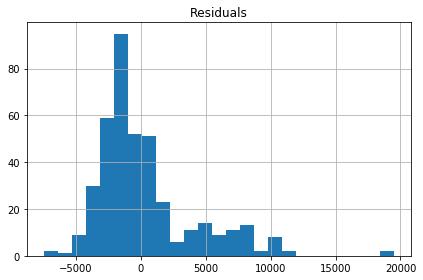

NN Regression Train score -0.000, NN Regression Valid score: -0.005 



Regression statistics

                      Mean Error (ME) : 0.0002
       Root Mean Squared Error (RMSE) : 3697.0348
            Mean Absolute Error (MAE) : 2740.3626
          Mean Percentage Error (MPE) : -8.2450
Mean Absolute Percentage Error (MAPE) : 23.3944

Regression statistics

                      Mean Error (ME) : 209.2876
       Root Mean Squared Error (RMSE) : 3827.6814
            Mean Absolute Error (MAE) : 2788.7988
          Mean Percentage Error (MPE) : -6.6447
Mean Absolute Percentage Error (MAPE) : 23.0192


In [41]:
car_df = MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=2, learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

car_df.fit(train_X, train_y.values.ravel())

car_df_pred = car_df.predict(valid_X)

result = pd.DataFrame({'Predicted': car_df_pred, 'Actual': valid_y.values.ravel(),
                       'Residual': valid_y.values.ravel() - car_df_pred})
print(result.head(20))

# Compute common accuracy measures
car_df_pred = car_df.predict(valid_X)
all_residuals = valid_y.values.ravel() - car_df_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Partition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

#Regression Stats and Model Score
print('NN Regression Train score %.3f, NN Regression Valid score: %.3f \n\n' % 
      (car_df.score(train_X,train_y),
       car_df.score(valid_X, valid_y)))
regressionSummary(train_y.values.ravel(), car_df.predict(train_X))
regressionSummary(valid_y.values.ravel(), car_df.predict(valid_X))

### Search Parameters for Better Model

In [19]:
param_grid = {
    'hidden_layer_sizes': [(1,1,1), (2,1,2), (3,1,3), (4,1,4), (5,1,5),
                           (1,2,1), (2,2,2), (3,2,3), (4,2,4), (5,2,5),
                          (1,3,1), (2,3,2), (3,3,3), (4,3,4), (5,3,5),
                          (1,4,1), (2,4,2), (3,4,3), (4,4,4), (5,4,5),
                          (1,5,1), (2,5,2), (3,5,3), (4,5,4), (5,5,5)],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'solver' : ['lbfgs', 'sgd', 'adam'],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init' : [.001, .0,1, .1, 1],
    'early_stopping': [True],
    
}
gridSearch = GridSearchCV(MLPRegressor(activation='relu', solver='lbfgs', random_state=1), 
                          param_grid, cv=3, n_jobs=-1, return_train_score=True)
gridSearch.fit(train_X, train_y.values.ravel())
print("\n The best estimator across ALL searched params:\n",
      gridSearch.best_estimator_)
print('\n\n Best Score: ', gridSearch.best_score_)
gridSearch.best_params_


 The best estimator across ALL searched params:
 MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(4, 4, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)


 Best Score:  0.8773907368721742


{'activation': 'relu',
 'early_stopping': True,
 'hidden_layer_sizes': (4, 4, 4),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'solver': 'lbfgs'}

### Predicted Residuals and Histogram

       Predicted  Actual     Residual
0   10450.292713   11500  1049.707287
1    9555.825788    8950  -605.825788
2   10254.694951   11450  1195.305049
3   12430.305416   11450  -980.305416
4   12409.607872   11950  -459.607872
5    9519.626535    9995   475.373465
6   12444.632325   13500  1055.367675
7    9057.216164    7950 -1107.216164
8   11593.518913    9900 -1693.518913
9   21122.147219   21950   827.852781
10  11148.286797   11950   801.713203
11  20156.167008   19950  -206.167008
12  10004.985013    9950   -54.985013
13  13416.515095   14950  1533.484905
14   9616.778567   10495   878.221433
15  17657.223891   15950 -1707.223891
16  18596.667010   19450   853.332990
17  15726.835515   16900  1173.164485
18  12007.991895   11250  -757.991895
19  11321.433964   11750   428.566036
0.81


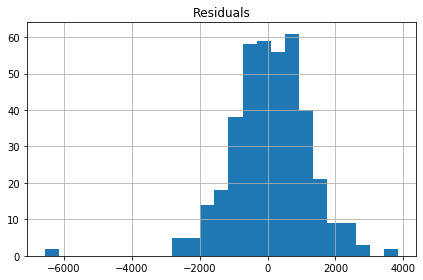

NN Regression Train score 0.902, NN Regression Valid score: 0.907 



Regression statistics

                      Mean Error (ME) : -0.7813
       Root Mean Squared Error (RMSE) : 1155.7026
            Mean Absolute Error (MAE) : 841.4988
          Mean Percentage Error (MPE) : -1.0942
Mean Absolute Percentage Error (MAPE) : 7.5917

Regression statistics

                      Mean Error (ME) : 87.2429
       Root Mean Squared Error (RMSE) : 1166.2723
            Mean Absolute Error (MAE) : 874.6649
          Mean Percentage Error (MPE) : -0.6466
Mean Absolute Percentage Error (MAPE) : 7.9862


In [42]:
car_df = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(4, 4, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

car_df.fit(train_X, train_y.values.ravel())

car_df_pred = car_df.predict(valid_X)

result = pd.DataFrame({'Predicted': car_df_pred, 'Actual': valid_y.values.ravel(),
                       'Residual': valid_y.values.ravel() - car_df_pred})
print(result.head(20))

# Compute common accuracy measures
car_df_pred = car_df.predict(valid_X)
all_residuals = valid_y.values.ravel() - car_df_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

# Plot Accuracy of Training and Vald(or Test) Partition
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

#Regression Stats and Model Score
print('NN Regression Train score %.3f, NN Regression Valid score: %.3f \n\n' % 
      (car_df.score(train_X,train_y),
       car_df.score(valid_X, valid_y)))
regressionSummary(train_y.values.ravel(), car_df.predict(train_X))
regressionSummary(valid_y.values.ravel(), car_df.predict(valid_X))

# Discriminant Analysis

In [20]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pylab as plt
from dmba import classificationSummary

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

no display found. Using non-interactive Agg backend
D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


### Prediction of Ownership

In [15]:
mower_df = pd.read_csv('RidingMowers.csv')
da_reg = LinearDiscriminantAnalysis()
da_reg.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])

result_df = mower_df.copy()
result_df.index = result_df.index + 1
result_df['Dec. Function'] = da_reg.decision_function(mower_df.drop(columns=['Ownership']))
result_df['Prediction'] = da_reg.predict(mower_df.drop(columns=['Ownership']))
result_df['p(Owner)'] = da_reg.predict_proba(mower_df.drop(columns=['Ownership']))[:, 1]

print(result_df)
plt(result_df)

    Income  Lot_Size Ownership  Dec. Function Prediction  p(Owner)
1     60.0      18.4     Owner      -1.277545   Nonowner  0.217968
2     85.5      16.8     Owner       0.022032      Owner  0.505508
3     64.8      21.6     Owner       1.716152      Owner  0.847632
4     61.5      20.8     Owner       0.757244      Owner  0.680755
5     87.0      23.6     Owner       5.511634      Owner  0.995977
6    110.1      19.2     Owner       4.372141      Owner  0.987533
7    108.0      17.6     Owner       2.905362      Owner  0.948111
8     82.8      22.4     Owner       4.148445      Owner  0.984456
9     69.0      20.0     Owner       0.880823      Owner  0.706993
10    93.0      20.8     Owner       3.914499      Owner  0.980440
11    51.0      22.0     Owner       0.647047      Owner  0.656345
12    81.0      20.0     Owner       2.083587      Owner  0.889298
13    75.0      19.6  Nonowner       1.168131      Owner  0.762807
14    52.8      20.8  Nonowner      -0.114760   Nonowner  0.47

TypeError: 'module' object is not callable

### Prediction of Multi-class Variable

In [21]:
accidents_df = pd.read_csv('accidents.csv')
lda_reg = LinearDiscriminantAnalysis()
lda_reg.fit(accidents_df.drop(columns=['MAX_SEV']), accidents_df['MAX_SEV'])

print('Coefficients and intercept')
fct = pd.DataFrame([lda_reg.intercept_], columns=lda_reg.classes_, index=['Constant'])
fct = fct.append(pd.DataFrame(lda_reg.coef_.transpose(), columns=lda_reg.classes_, 
                              index=list(accidents_df.columns)[:-1]))
print(fct)
print()
classificationSummary(accidents_df['MAX_SEV'], 
                      lda_reg.predict(accidents_df.drop(columns=['MAX_SEV'])),
                      class_names=lda_reg.classes_)
accidents_df.MAX_SEV.value_counts()

Coefficients and intercept
                    fatal  no-injury  non-fatal
Constant        -1.972659  -0.891172  -0.610471
RushHour        -0.996411   0.033430  -0.015774
WRK_ZONE        -0.457188   0.220012  -0.204480
WKDY            -1.471777   0.165707  -0.135404
INT_HWY          0.755344  -0.075816   0.060599
LGTCON_day       0.009515  -0.031421   0.030124
LEVEL            0.976626  -0.082717   0.063598
SPD_LIM          0.048033   0.004381  -0.005014
SUR_COND_dry    -5.999809  -0.164874   0.257895
TRAF_two_way     0.752985  -0.012844  -0.000048
WEATHER_adverse -6.596690   0.079166   0.032564

Confusion Matrix (Accuracy 0.5283)

          Prediction
   Actual     fatal no-injury non-fatal
    fatal         1         1         3
no-injury         6       114       172
non-fatal         6        95       202


non-fatal    303
no-injury    292
fatal          5
Name: MAX_SEV, dtype: int64

# Association Rules

In [27]:
%matplotlib inline

from pathlib import Path

import heapq
from collections import defaultdict

import pandas as pd
import matplotlib.pylab as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


### Load Data and Create Rules

In [28]:
fp_df = pd.read_csv('Faceplate.csv')
fp_df.set_index('Transaction', inplace=True)

# create frequent itemsets
itemsets = apriori(fp_df, min_support=0.2, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)
rules.sort_values(by=['lift'], ascending=False).head(6)

print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(6))

       antecedents   consequents  support  confidence      lift  leverage
14    (Red, White)       (Green)      0.2         0.5  2.500000      0.12
15         (Green)  (Red, White)      0.2         1.0  2.500000      0.12
4          (Green)         (Red)      0.2         1.0  1.666667      0.08
13  (Green, White)         (Red)      0.2         1.0  1.666667      0.08
7         (Orange)       (White)      0.2         1.0  1.428571      0.06
8          (Green)       (White)      0.2         1.0  1.428571      0.06


### Filter to get Rules with Single Consequents only

In [29]:
rules[[len(c) == 1 for c in rules.consequents]].sort_values(by=['lift'], ascending=False).head(6)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,"(Red, White)",(Green),0.4,0.2,0.2,0.5,2.500000,0.12,1.6
4,(Green),(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
13,"(Green, White)",(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
7,(Orange),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
8,(Green),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
12,"(Green, Red)",(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf


### Book Sales Example

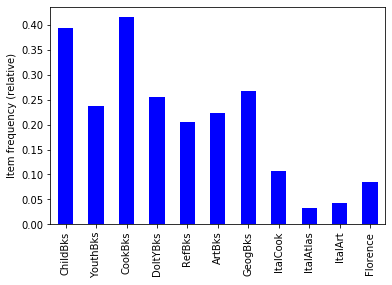

In [35]:
# load dataset
all_books_df = pd.read_csv('CharlesBookClub.csv')

# create the binary incidence matrix
ignore = ['Seq#', 'ID#', 'Gender', 'M', 'R', 'F', 'FirstPurch', 'Related Purchase',
          'Mcode', 'Rcode', 'Fcode', 'Yes_Florence', 'No_Florence']
count_books = all_books_df.drop(columns=ignore)
count_books[count_books > 0] = 1

# determine item frequencies
itemFrequency = count_books.sum(axis=0) / len(count_books)

# and plot as histogram
ax = itemFrequency.plot.bar(color='blue')
plt.ylabel('Item frequency (relative)')
plt.show()

### Create Frequent Itemsets and Rules

In [44]:
itemsets = apriori(count_books, min_support=200/4000, use_colnames=True)
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)

print('Number of rules', len(rules))

# Display 25 rules with highest lift
rules.sort_values(by=['lift'], ascending=False).head(25)

pd.set_option('precision', 5)
pd.set_option('display.width', 100)
print(rules.sort_values(by=['lift'], ascending=False).drop(columns=['antecedent support', 'consequent support', 'conviction']).head(25))
pd.set_option('precision', 6)

Number of rules 81
                      antecedents          consequents  support  confidence     lift  leverage
64             (YouthBks, RefBks)  (ChildBks, CookBks)  0.05525     0.68000  2.80992   0.03559
73             (DoItYBks, RefBks)  (ChildBks, CookBks)  0.06125     0.66216  2.73621   0.03886
60           (DoItYBks, YouthBks)  (ChildBks, CookBks)  0.06700     0.64891  2.68145   0.04201
80              (GeogBks, RefBks)  (ChildBks, CookBks)  0.05025     0.61468  2.54000   0.03047
69            (GeogBks, YouthBks)  (ChildBks, CookBks)  0.06325     0.60526  2.50109   0.03796
77            (GeogBks, DoItYBks)  (ChildBks, CookBks)  0.06050     0.59901  2.47525   0.03606
65   (ChildBks, GeogBks, CookBks)           (YouthBks)  0.06325     0.57763  2.42445   0.03716
71    (ChildBks, CookBks, RefBks)           (DoItYBks)  0.06125     0.59179  2.32301   0.03488
47            (GeogBks, DoItYBks)           (YouthBks)  0.05450     0.53960  2.26486   0.03044
61    (ChildBks, CookBks, RefBk

### Sort by Confidence

In [43]:
print(rules.sort_values(by=['confidence'], ascending=False).drop(columns=['antecedent support', 'consequent support', 'conviction']).head(25))
pd.set_option('precision', 6)

             antecedents consequents  support  confidence      lift  leverage
43    (YouthBks, RefBks)   (CookBks)  0.06825    0.840000  2.021661  0.034491
13  (ChildBks, YouthBks)   (CookBks)  0.12000    0.813559  1.958025  0.058714
41  (DoItYBks, YouthBks)   (CookBks)  0.08375    0.811138  1.952197  0.040850
26    (ChildBks, RefBks)   (CookBks)  0.10350    0.807018  1.942280  0.050212
50    (DoItYBks, RefBks)   (CookBks)  0.07450    0.805405  1.938400  0.036066
22  (ChildBks, DoItYBks)   (CookBks)  0.12775    0.791022  1.903783  0.060647
54     (GeogBks, RefBks)   (CookBks)  0.06450    0.788991  1.898895  0.030533
17  (DoItYBks, YouthBks)  (ChildBks)  0.08025    0.777240  1.972690  0.039570
46   (GeogBks, YouthBks)   (CookBks)  0.08025    0.767943  1.848237  0.036830
34    (DoItYBks, RefBks)  (ChildBks)  0.07100    0.767568  1.948141  0.034555
53   (GeogBks, DoItYBks)   (CookBks)  0.07750    0.767327  1.846755  0.035534
18    (YouthBks, RefBks)  (ChildBks)  0.06200    0.763077  1.936

### Filter rules by number of antecedents (maximum 2) and consequents (maximum 1)

In [42]:
rules = rules[[len(c) <= 2 for c in rules.antecedents]]
rules = rules[[len(c) == 1 for c in rules.consequents]]

rules.sort_values(by=['lift'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
47,"(GeogBks, DoItYBks)",(YouthBks),0.10100,0.23825,0.05450,0.539604,2.264864,0.030437,1.654554
33,"(ChildBks, RefBks)",(DoItYBks),0.12825,0.25475,0.07100,0.553606,2.173135,0.038328,1.669490
19,"(ChildBks, GeogBks)",(YouthBks),0.14625,0.23825,0.07550,0.516239,2.166797,0.040656,1.574642
45,"(GeogBks, CookBks)",(YouthBks),0.15625,0.23825,0.08025,0.513600,2.155719,0.043023,1.566098
16,"(ChildBks, YouthBks)",(DoItYBks),0.14750,0.25475,0.08025,0.544068,2.135693,0.042674,1.634563
51,"(CookBks, RefBks)",(DoItYBks),0.13975,0.25475,0.07450,0.533095,2.092619,0.038899,1.596148
23,"(ChildBks, CookBks)",(DoItYBks),0.24200,0.25475,0.12775,0.527893,2.072198,0.066101,1.578560
48,"(GeogBks, YouthBks)",(DoItYBks),0.10450,0.25475,0.05450,0.521531,2.047227,0.027879,1.557573
42,"(CookBks, YouthBks)",(DoItYBks),0.16100,0.25475,0.08375,0.520186,2.041948,0.042735,1.553207
43,"(YouthBks, RefBks)",(CookBks),0.08125,0.41550,0.06825,0.840000,2.021661,0.034491,3.653125


### Sort by Confidence

In [72]:
rules.sort_values(by=['confidence'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
62,"(ChildBks, YouthBks, RefBks)",(CookBks),0.06200,0.4155,0.05525,0.891129,2.144715,0.029489,5.368741
70,"(ChildBks, DoItYBks, RefBks)",(CookBks),0.07100,0.4155,0.06125,0.862676,2.076236,0.031749,4.256359
78,"(ChildBks, GeogBks, RefBks)",(CookBks),0.05925,0.4155,0.05025,0.848101,2.041158,0.025632,3.847958
43,"(YouthBks, RefBks)",(CookBks),0.08125,0.4155,0.06825,0.840000,2.021661,0.034491,3.653125
66,"(ChildBks, GeogBks, YouthBks)",(CookBks),0.07550,0.4155,0.06325,0.837748,2.016242,0.031880,3.602429
57,"(ChildBks, DoItYBks, YouthBks)",(CookBks),0.08025,0.4155,0.06700,0.834891,2.009365,0.033656,3.540085
72,"(CookBks, DoItYBks, RefBks)",(ChildBks),0.07450,0.3940,0.06125,0.822148,2.086669,0.031897,3.407321
74,"(ChildBks, GeogBks, DoItYBks)",(CookBks),0.07375,0.4155,0.06050,0.820339,1.974342,0.029857,3.253349
13,"(ChildBks, YouthBks)",(CookBks),0.14750,0.4155,0.12000,0.813559,1.958025,0.058714,3.135045
41,"(DoItYBks, YouthBks)",(CookBks),0.10325,0.4155,0.08375,0.811138,1.952197,0.040850,3.094853


# Naive Bayes Classifier

In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pylab as plt
from dmba import classificationSummary, gainsChart

%cd D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets

no display found. Using non-interactive Agg backend
D:\CSU Global Data Analytics\MIS510 Python\DMBA-Python-datasets


### Load Data for Predicting 

In [2]:
delays_df = pd.read_csv('FlightDelays.csv')

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'

X = pd.get_dummies(delays_df[predictors])
y = (delays_df[outcome] == 'delayed').astype(int)
classes = ['ontime', 'delayed']

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# run naive Bayes
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_valid_pred = delays_nb.predict(X_valid)
y_train_pred = delays_nb.predict(X_train)

In [6]:
delays_df = pd.read_csv('FlightDelays.csv')

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')
delays_df['Flight Status'] = delays_df['Flight Status'].astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'

X = pd.get_dummies(delays_df[predictors])
y = delays_df['Flight Status']
classes = list(y.cat.categories)

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# run naive Bayes
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_valid_pred = delays_nb.predict(X_valid)
y_train_pred = delays_nb.predict(X_train)

### Probability of Flight Status

In [3]:
# split the original data frame into a train and test using the same random_state
train_df, valid_df = train_test_split(delays_df, test_size=0.4, random_state=1)

pd.set_option('precision', 4)

# probability of flight status
print(train_df['Flight Status'].value_counts() / len(train_df))
print()

for predictor in predictors:
    # construct the frequency table
    df = train_df[['Flight Status', predictor]]
    freqTable = df.pivot_table(index='Flight Status', columns=predictor, aggfunc=len)

    # divide each row by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()
pd.reset_option('precision')

ontime     0.8023
delayed    0.1977
Name: Flight Status, dtype: float64

DAY_WEEK            1       2       3       4       5      6       7
Flight Status                                                       
delayed        0.1916  0.1494  0.1149  0.1264  0.1877  0.069  0.1609
ontime         0.1246  0.1416  0.1445  0.1794  0.1690  0.136  0.1048

CRS_DEP_TIME       6       7       8       9       10      11      12      13  \
Flight Status                                                                   
delayed        0.0345  0.0536  0.0651  0.0192  0.0307  0.0115  0.0498  0.0460   
ontime         0.0623  0.0633  0.0850  0.0567  0.0519  0.0340  0.0661  0.0746   

CRS_DEP_TIME       14      15      16      17      18      19      20      21  
Flight Status                                                                  
delayed        0.0383  0.2031  0.0728  0.1533  0.0192  0.0996  0.0153  0.0881  
ontime         0.0576  0.1171  0.0774  0.1001  0.0349  0.0397  0.0264  0.0529  

ORIG

### Calculate Probability Based on Predictors

In [4]:
# P(delayed | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_delayed = 0.0958 * 0.1609 * 0.0307 * 0.4215 * 0.5211 * 0.1977
# P(ontime | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_ontime = 0.2040 * 0.1048 * 0.0519 * 0.5779 * 0.6478 * 0.8023
print('P_hat_delayed ~ ', P_hat_delayed)
print('P_hat_ontime ~ ', P_hat_ontime)

print('P(delayed|...) = ', P_hat_delayed / (P_hat_delayed + P_hat_ontime))
print('P(ontime|...) = ', P_hat_ontime / (P_hat_delayed + P_hat_ontime))

P_hat_delayed ~  2.0548742506526157e-05
P_hat_ontime ~  0.00033326464123921066
P(delayed|...) =  0.05807791183301656
P(ontime|...) =  0.9419220881669834


### Classify a Specific Flight by Searching Dataset to find Row with same predictors

In [7]:
# Subset a specific set
df = pd.concat([pd.DataFrame({'actual': y_valid, 'predicted': y_valid_pred}),
                pd.DataFrame(predProb_valid, index=y_valid.index)], axis=1)
mask = ((X_valid.CARRIER_DL == 1) & (X_valid.DAY_WEEK_7 == 1) & (X_valid.CRS_DEP_TIME_10 == 1) & 
        (X_valid.DEST_LGA == 1) & (X_valid.ORIGIN_DCA == 1))

print(df[mask])

      actual predicted         0         1
1225  ontime    ontime  0.057989  0.942011


### Classification Accuracy

Confusion Matrix (Accuracy 0.7955)

        Prediction
 Actual delayed  ontime
delayed      52     209
 ontime      61     998

Confusion Matrix (Accuracy 0.7821)

        Prediction
 Actual delayed  ontime
delayed      26     141
 ontime      51     663


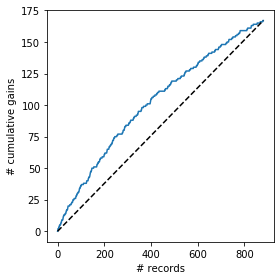

In [77]:
classificationSummary(y_train, y_train_pred, class_names=classes) 

print()

classificationSummary(y_valid, y_valid_pred, class_names=classes)
df = pd.DataFrame({'actual': 1 - y_valid.cat.codes, 'prob': predProb_valid[:, 0]})
df = df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
gainsChart(df.actual, ax=ax)

plt.tight_layout()
plt.show()

# Markov Chain Monte Carlo: METROPOLIS-HASTINGS

In [ ]:
%matplotlib inline
%matplotlib notebook

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

### Set up Metropolis-Hastings and set symmetric proposal distribution

In [52]:
def log_prob(x):
     return -0.5 * np.sum(x ** 2)
def proposal(x, stepsize):
    return np.random.uniform(low=x - 0.5 * stepsize, 
                             high=x + 0.5 * stepsize, 
                             size=x.shape)

### Acceptance Probability

In [59]:
def p_acc(x_new, x_old, log_prob):
    return min(1, np.exp(log_prob(x_new) - log_prob(x_old)))

In [54]:
def sample_MH(x_old, log_prob, stepsize):
    x_new = proposal(x_old, stepsize)
    # here we determine whether we accept the new state or not:
    # we draw a random number uniformly from [0,1] and compare
    # it with the acceptance probability
    accept = np.random.random() < p_acc(x_new, x_old, log_prob)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

### Function that iteratively calls sample_MH 

In [55]:
def build_MH_chain(init, stepsize, n_total, log_prob):

    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_MH(chain[-1], log_prob, stepsize)
        chain.append(state)
        n_accepted += accept
    
    acceptance_rate = n_accepted / float(n_total)
    
    return chain, acceptance_rate

Acceptance rate: 0.717
Last ten states of chain: 0.68581, 0.23691, 0.64704, 0.64704, -0.50445, -0.91060, -1.35131, -1.35131, -0.36773, 0.03590


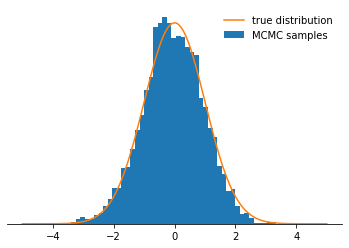

In [64]:
chain, acceptance_rate = build_MH_chain(np.array([2.0]), 3.0, 10000, log_prob)
chain = [state for state, in chain]
print("Acceptance rate: {:.3f}".format(acceptance_rate))
last_states = ", ".join("{:.5f}".format(state) 
                        for state in chain[-10:])
print("Last ten states of chain: " + last_states)


def despine(ax, spines=('top', 'left', 'right')):
    for spine in spines:
        ax.spines[spine].set_visible(False)
def plot_samples(chain, log_prob, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 5), legend=True):
    from scipy.integrate import quad
    
    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # we numerically calculate the normalization constant of our PDF
    if normalize:
        Z, _ = quad(lambda x: np.exp(log_prob(x)), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [np.exp(log_prob(x)) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)
    
fig, ax = plt.subplots()
plot_samples(chain[500:], log_prob, ax)
despine(ax)
ax.set_yticks(())
plt.show()

### Example of Poor Acceptance Rate with Low Stepsize

Acceptance rate: 0.106


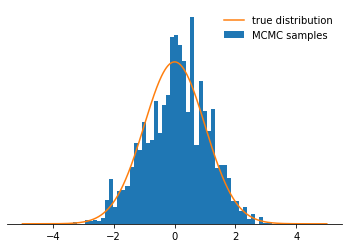

In [65]:
def sample_and_display(init_state, stepsize, n_total, n_burnin, log_prob):
    chain, acceptance_rate = build_MH_chain(init_state, stepsize, n_total, log_prob)
    print("Acceptance rate: {:.3f}".format(acceptance_rate))
    fig, ax = plt.subplots()
    plot_samples([state for state, in chain[n_burnin:]], log_prob, ax)
    despine(ax)
    ax.set_yticks(())
    plt.show()
    
sample_and_display(np.array([2.0]), 30, 10000, 500, log_prob)

### Example of Poor Distribution with n_total

Acceptance rate: 0.989


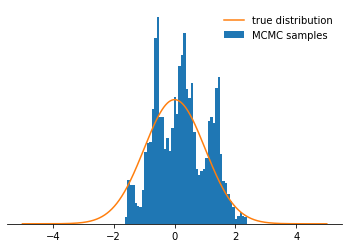

In [71]:
sample_and_display(np.array([2.0]), 0.1, 10000, 500, log_prob)

### Good Distribution and Acceptance, takes awhile to run

Acceptance rate: 0.988


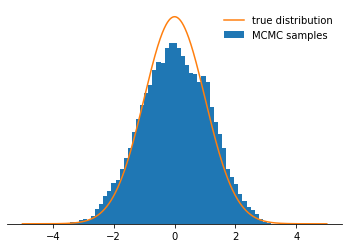

In [67]:
sample_and_display(np.array([2.0]), 0.1, 500000, 25000, log_prob)